In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

'metrics_history': metrics_history,
'test_metrics': test_metrics,
'real_test_metrics': real_test_metrics

In [2]:
classifier_metrics = torch.load("classifier_models/classifier122/classifier.pth",weights_only=False)
metrics_history = classifier_metrics['metrics_history']
test_metrics = classifier_metrics['test_metrics']
real_test_metrics  =classifier_metrics['real_test_metrics']

metrics_history = {
        'epoch': [],
        'train_loss': [],
        'train_accuracy': [],
        'train_recall': [],
        'train_precision': [],
        'train_f1': [],
        'train_auroc': [],
        'train_conf_mat': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_recall': [],
        'val_precision': [],
        'val_f1': [],
        'val_auroc': [],
        'val_conf_mat': []
    }

In [3]:
train_loss = metrics_history['train_loss']
train_acc = metrics_history['train_accuracy']
val_acc = metrics_history['val_accuracy']
val_loss = metrics_history['val_loss']
epochs = metrics_history['epoch']
print(train_acc[9])
print(val_acc[9])

0.8130497932434082
0.821707010269165


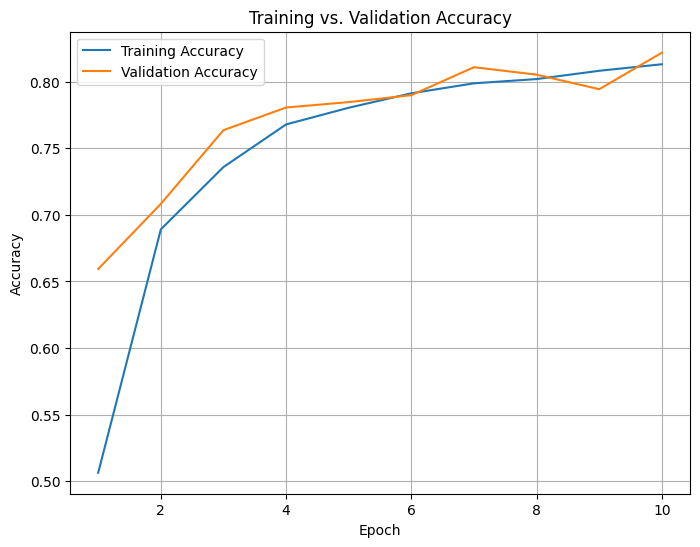

In [4]:
plt.figure(figsize=(8,6))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

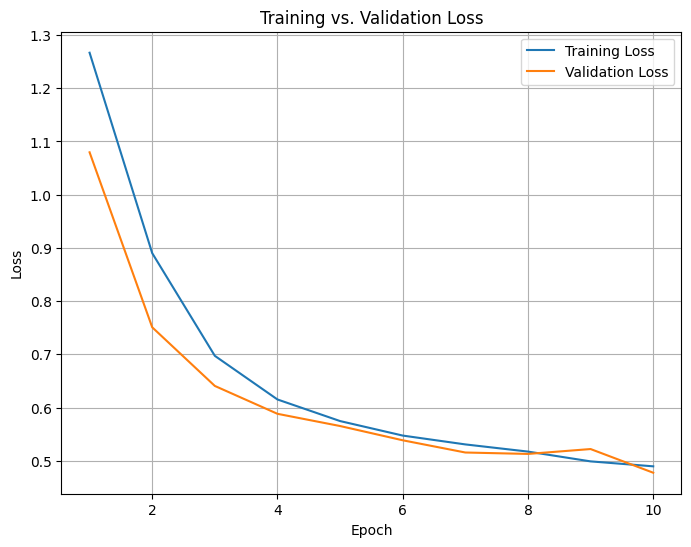

In [5]:
plt.figure(figsize=(8,6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
train_conf_mat = metrics_history['train_conf_mat'][9]
val_conf_mat = metrics_history['val_conf_mat'][9]
class_names = ['None', 'MI', 'Stroke', 'Syncope']

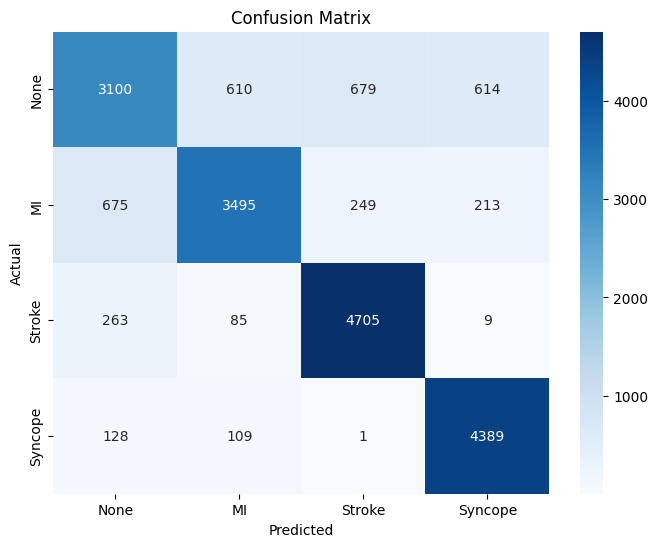

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(train_conf_mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

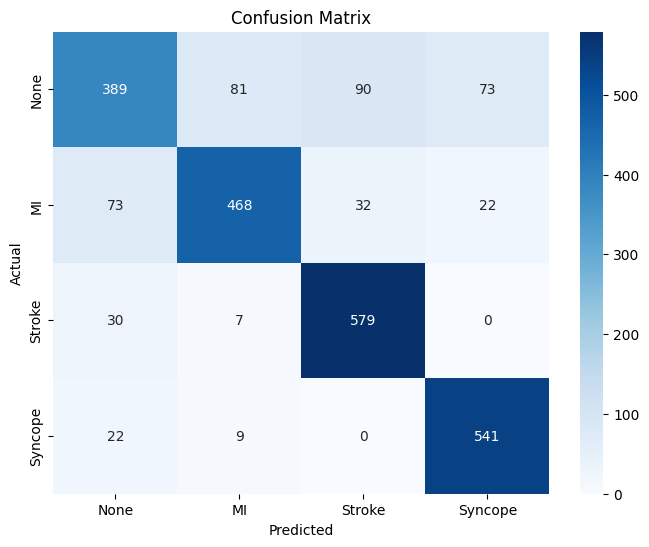

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(val_conf_mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [9]:
from torch.utils.data import TensorDataset, DataLoader
from gan_scripts.preprocessing_utils import evaluate_on_test, reorder_features
from gan_scripts.ECG_classifier import Classifier
classifier_metrics = torch.load("classifier_models/classifier110/classifier.pth",weights_only=False)
BATCH_SIZE = 128
ecg_data = np.load("real_ecg2.npy", allow_pickle=True)
crf_data = np.load("real_crf2.npy", allow_pickle=True)
crf_data = crf_data.tolist()
vascular_events = [val['Vascular event'] for val in crf_data]
keys = [k for k in crf_data[0].keys() if k != 'Vascular event']
# Create a 2D NumPy array where each row corresponds to the values (in the same order) of the non-vascular features
non_vasc_features = np.array([[d[k] for k in keys] for d in crf_data])
non_vasc_features_reordered = np.array(
    [reorder_features(row) for row in non_vasc_features])
ecg_data = torch.tensor(ecg_data, dtype=torch.float32)
crf_data = torch.tensor(non_vasc_features_reordered, dtype=torch.float32)
labels = torch.tensor(vascular_events, dtype=torch.long)
ecg_data = ecg_data.permute(0, 2, 1)
real_test_dataset = TensorDataset(ecg_data, crf_data, labels)
testloader = DataLoader(
    real_test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier(640,7,4)
classifier.load_state_dict(classifier_metrics['model_state_dict'])
classifier.eval()
classifier.to(device=device)
print(f"Train acc: {classifier_metrics['metrics_history']['train_accuracy'][9]}")
print(f"val acc: {classifier_metrics['metrics_history']['val_accuracy'][9]}")
print(f"Real Test acc: {classifier_metrics['real_test_metrics']['accuracy']}")
print(f"Test acc: {classifier_metrics['test_metrics']['accuracy']}")
print(classifier_metrics['real_test_metrics']['confusion_matrix'])
metrics = evaluate_on_test(classifier, testloader,device)
plt.figure(figsize=(8,6))
sns.heatmap(metrics['confusion_matrix'], annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

ModuleNotFoundError: No module named 'preprocessing_utils'

In [9]:
# from torchviz import make_dot
# from gan_scripts.ECG_classifier import Classifier
# classifier = Classifier(640,7,4)
# classifier.load_state_dict(classifier_metrics['model_state_dict'])
# classifier.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = torch.randn(1, 3, 640).to(device)
dummy_risk = torch.tensor([[1, 1, 1, 1, 1, 1, 1]], dtype=torch.float32)
# output = classifier(dummy_input,dummy_risk)
# dot = make_dot(output, params=dict(classifier.named_parameters()))
# dot.render("classifier_graph", format="png")

In [10]:
import torch
from WGAN_torch import Generator, Critic
WGAN_metrics = torch.load("gan/WGAN_models/pretrain/CWGAN.pth", weights_only=False)
generator = Generator(640,3,50)
generator.load_state_dict(WGAN_metrics['gen_state_dict'])
generator.eval()
generator.to(device)

Generator(
  (fc): Linear(in_features=50, out_features=20480, bias=True)
  (cnn1): Sequential(
    (0): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (3): ReLU()
  )
  (lstm1): LSTM(128, 50, batch_first=True, bidirectional=True)
  (lstm2): LSTM(100, 50, batch_first=True, bidirectional=True)
  (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (cnn2): Sequential(
    (0): Conv1d(100, 192, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): InstanceNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (3): Conv1d(192, 128, kernel_size=(17,), stride=(1,), padding=(8,))
    (4): LeakyReLU(negative_slope=0.2)
    (5): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (6): Conv1d(128, 64, kernel_size=(17,), stride=(1,), padding=(8,))
    (7): LeakyReLU(negative_sl

In [33]:
WGAN_metric = WGAN_metrics['metrics_history']
critic_loss = WGAN_metric['critic_loss']
mvdtw = WGAN_metric['mvdtw']
mmd = WGAN_metric['mmd']
epochs = WGAN_metric['epoch']
gen_loss = WGAN_metric['gen_loss']
print(critic_loss[49])
print(mvdtw[49])
print(mmd[49])
print(gen_loss[49])

-0.5297060054962082
1.6567672
0.08676746313278219
2.469517886036574


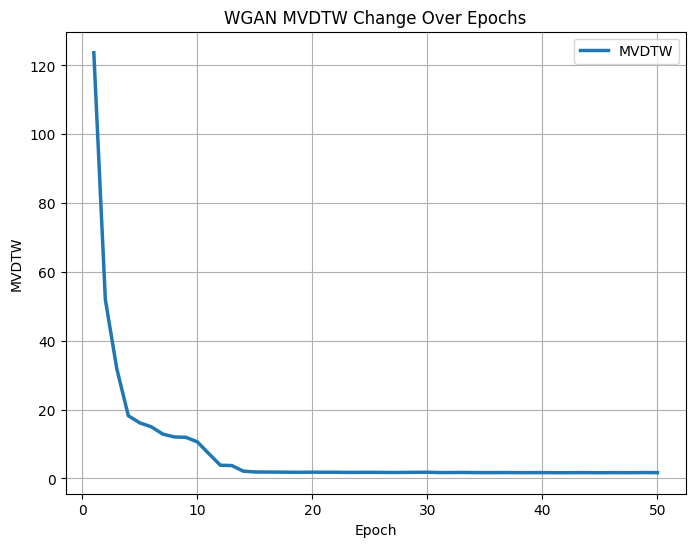

In [56]:
plt.figure(figsize=(8,6))
plt.plot(epochs, mvdtw, label='MVDTW', linewidth=2.5)
plt.xlabel('Epoch')
plt.ylabel('MVDTW')
plt.title('WGAN MVDTW Change Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

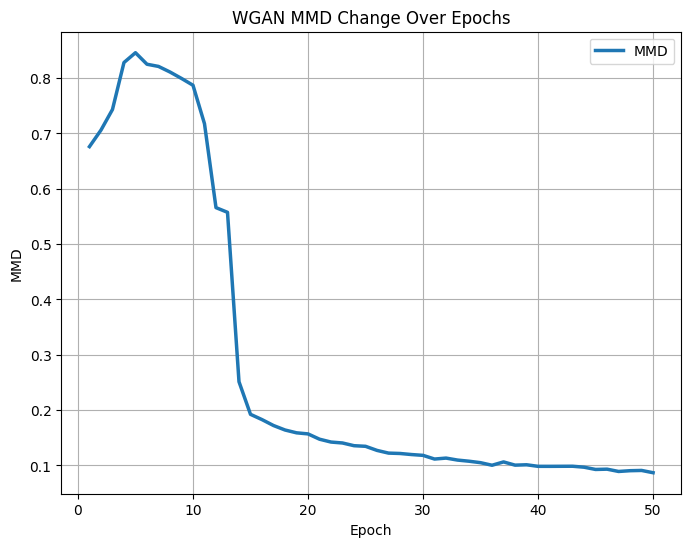

In [57]:
plt.figure(figsize=(8,6))
plt.plot(epochs, mmd, label='MMD', linewidth=2.5)
plt.xlabel('Epoch')
plt.ylabel('MMD')
plt.title('WGAN MMD Change Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

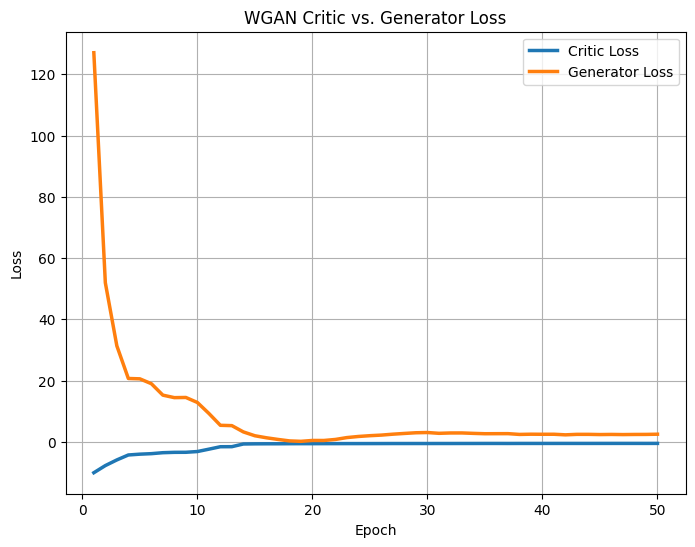

In [58]:
plt.figure(figsize=(8,6))
plt.plot(epochs, critic_loss, label='Critic Loss', linewidth=2.5)
plt.plot(epochs, gen_loss, label='Generator Loss', linewidth=2.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('WGAN Critic vs. Generator Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
CWGAN_metrics = torch.load("gan/CWGAN_models/pretrained/CWGAN.pth", weights_only=False)
cwgan_metric = CWGAN_metrics['metrics_history']
c_gen_loss = cwgan_metric['gen_loss']
c_critic_loss = cwgan_metric['critic_loss']
c_mvdtw = cwgan_metric['mvdtw']
c_mmd = cwgan_metric['mmd']

In [59]:
print(f"critic loss: {c_critic_loss[49]}")
print(f"mvdtw: {c_mvdtw[49]}")
print(f"mmd: {c_mmd[49]}")
print(f"gen loss: {c_gen_loss[49]}")

critic loss: -0.5452878233932313
mvdtw: 5.617915630340576
mmd: 0.027065955859565588
gen loss: -12.398992235698397


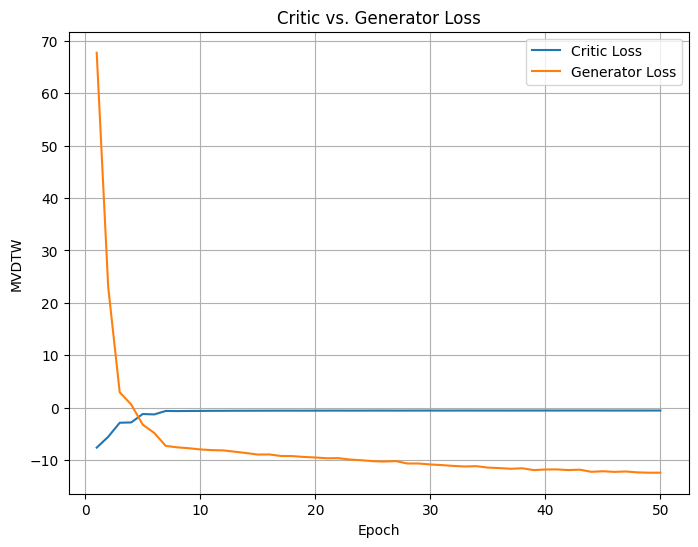

In [38]:
plt.figure(figsize=(8,6))
plt.plot(epochs, c_critic_loss, label='Critic Loss')
plt.plot(epochs, c_gen_loss, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('MVDTW')
plt.title('Critic vs. Generator Loss')
plt.legend()
plt.grid(True)
plt.show()

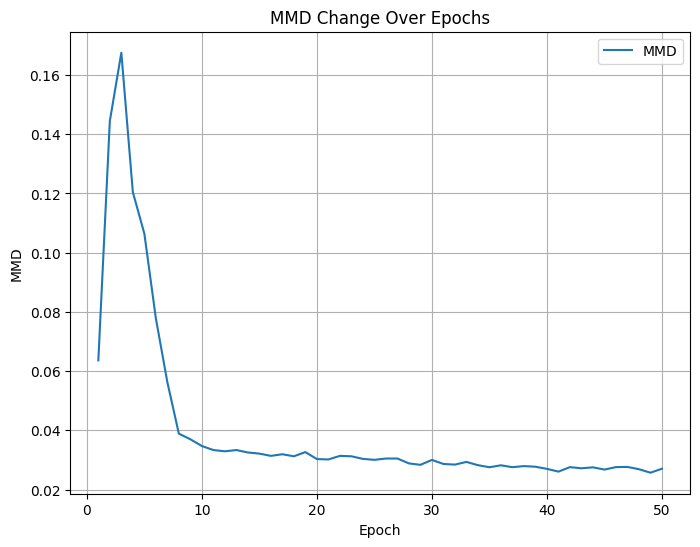

In [40]:
plt.figure(figsize=(8,6))
plt.plot(epochs, c_mmd, label='MMD')
plt.xlabel('Epoch')
plt.ylabel('MMD')
plt.title('MMD Change Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

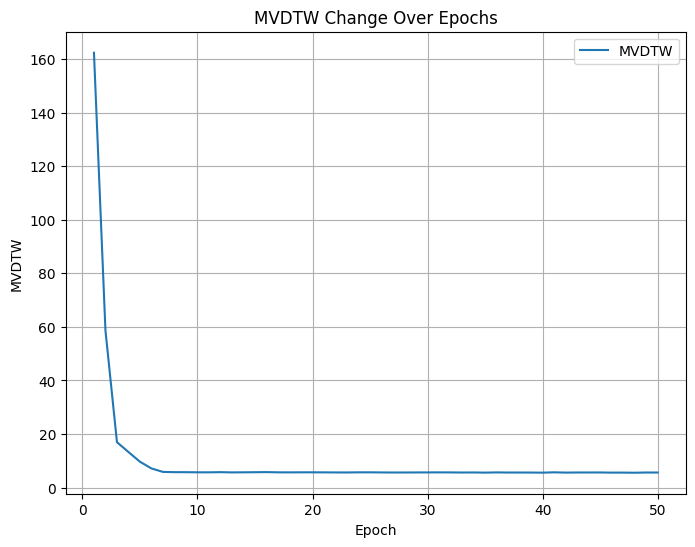

In [41]:
plt.figure(figsize=(8,6))
plt.plot(epochs, c_mvdtw, label='MVDTW')
plt.xlabel('Epoch')
plt.ylabel('MVDTW')
plt.title('MVDTW Change Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
CWGAN_metrics_64 = torch.load("gan/CWGAN_models/cwgan_64/CWGAN.pth", weights_only=False)
cwgan_metric_64 = CWGAN_metrics_64['metrics_history']
c_gen_loss_64 = cwgan_metric_64['gen_loss']
c_critic_loss_64 = cwgan_metric_64['critic_loss']
c_mvdtw_64 = cwgan_metric_64['mvdtw']
c_mmd_64 = cwgan_metric_64['mmd']

In [60]:
print(f"critic loss: {c_critic_loss_64[49]}")
print(f"mvdtw: {c_mvdtw_64[49]}")
print(f"mmd: {c_mmd_64[49]}")
print(f"gen loss: {c_gen_loss_64[49]}")

critic loss: -0.5319010357535074
mvdtw: 5.770975589752197
mmd: 0.030507311040205785
gen loss: -5.240647940408616


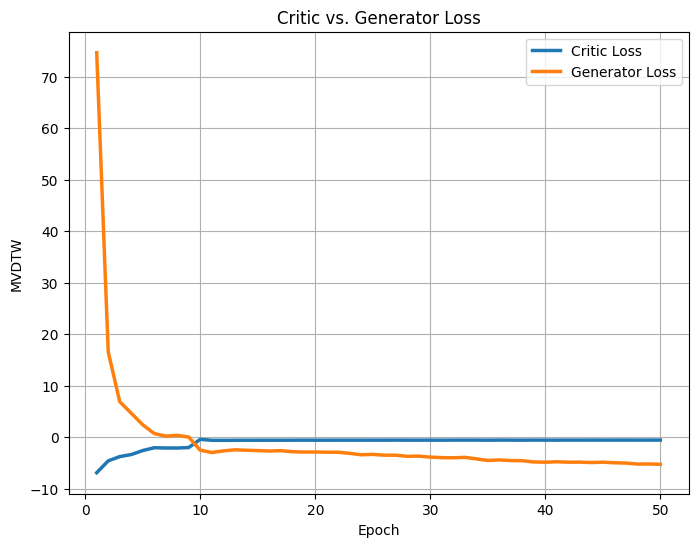

In [54]:
plt.figure(figsize=(8,6))
plt.plot(epochs, c_critic_loss_64, label='Critic Loss',linewidth="2.5")
plt.plot(epochs, c_gen_loss_64, label='Generator Loss',linewidth="2.5")
plt.xlabel('Epoch')
plt.ylabel('MVDTW')
plt.title('Critic vs. Generator Loss')
plt.legend()
plt.grid(True)
plt.show()

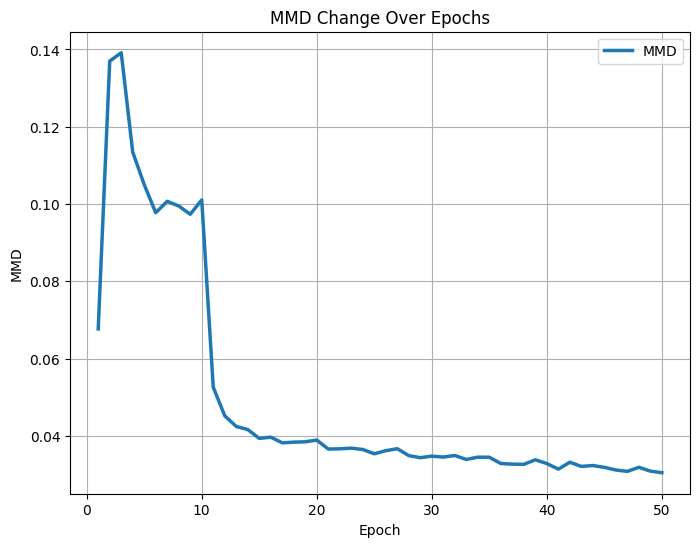

In [53]:
plt.figure(figsize=(8,6))
plt.plot(epochs, c_mmd_64, label='MMD',linewidth="2.5")
plt.xlabel('Epoch')
plt.ylabel('MMD')
plt.title('MMD Change Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

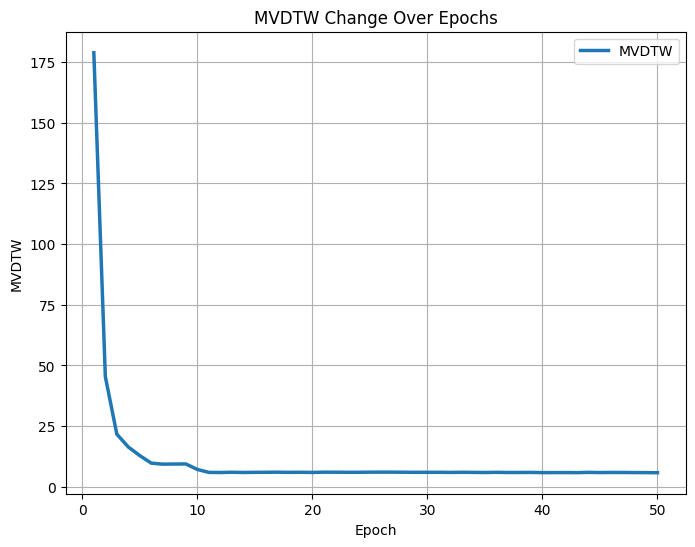

In [52]:
plt.figure(figsize=(8,6))
plt.plot(epochs, c_mvdtw_64, label='MVDTW', linewidth="2.5")
plt.xlabel('Epoch')
plt.ylabel('MVDTW')
plt.title('MVDTW Change Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
noise = torch.randn(1, 50, device=device)
noise.shape

torch.Size([1, 50])

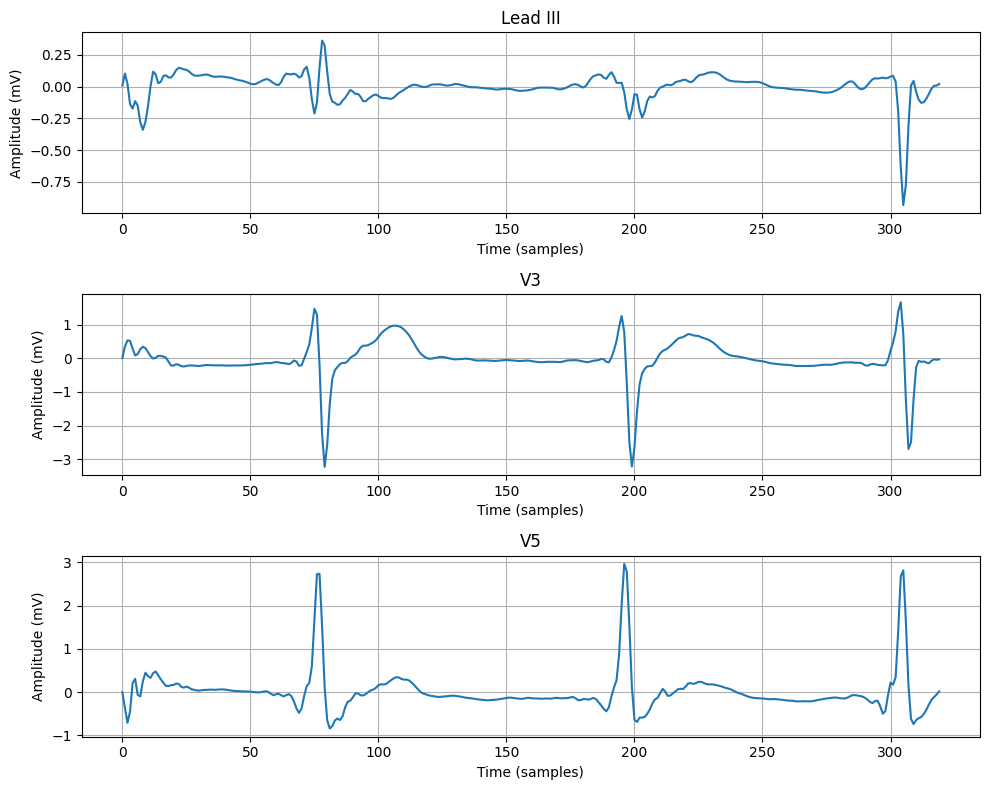

In [ ]:
import numpy as np
with torch.autograd.no_grad():
    dummy_input = torch.randn(1, 50, device=device)
    output = generator(dummy_input)
import os
from gan_scripts.preprocessing_utils import plot_generated_sample, per_lead_minmax_scaling, bandpass_filter
if os.path.exists("biased_ptbxl_ecgs.npy"):
    data = np.load("biased_ptbxl_ecgs.npy", allow_pickle=True)
    segments = [item for item in data]  # Collect segments from the saved data
    ecg_dataset = np.stack(segments)  # Stack all segments into a single array
    normalized_data, lead_mins, lead_maxs = per_lead_minmax_scaling(
        ecg_dataset=ecg_dataset)  # Normalize values in each lead between (-1,1)
plot_generated_sample(output,lead_mins,lead_maxs)

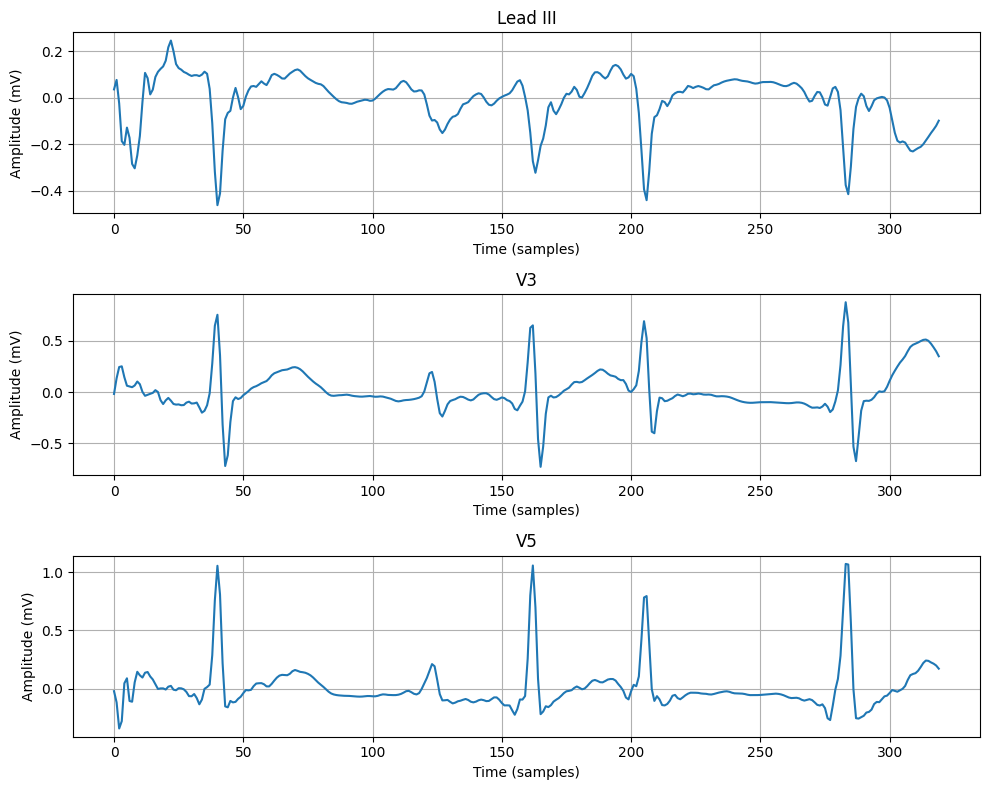

In [ ]:
with torch.autograd.no_grad():
    dummy_input = torch.randn(1, 50, device=device)
    output = generator(dummy_input)
from gan_scripts.preprocessing_utils import plot_generated_sample, per_lead_minmax_scaling, per_lead_inverse_scaling
plot_generated_sample(output,lead_mins,lead_maxs)

In [ ]:
from torchinfo import summary
summary(generator, input_data=(torch.randn(64,50,device=device)), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [64, 640, 3]              --
├─Linear: 1-1                            [64, 20480]               1,044,480
├─Sequential: 1-2                        [64, 128, 640]            --
│    └─Conv1d: 2-1                       [64, 64, 640]             14,400
│    └─ReLU: 2-2                         [64, 64, 640]             --
│    └─Conv1d: 2-3                       [64, 128, 640]            57,472
│    └─ReLU: 2-4                         [64, 128, 640]            --
├─LSTM: 1-3                              [64, 640, 100]            72,000
├─LayerNorm: 1-4                         [64, 640, 100]            200
├─LSTM: 1-5                              [64, 640, 100]            60,800
├─LayerNorm: 1-6                         [64, 640, 100]            (recursive)
├─Sequential: 1-7                        [64, 3, 640]              --
│    └─Conv1d: 2-5                       [64, 192, 6

In [ ]:
critic = Critic(640,3)
critic.load_state_dict(WGAN_metrics['critic_state_dict'])
critic.eval()
critic.to(device)

Critic(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(2,), padding=(4,))
  (conv2): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (conv3): Conv1d(128, 256, kernel_size=(9,), stride=(2,), padding=(2,))
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (mb_discrim): MiniBatchDiscrimination()
  (fc): Linear(in_features=20324, out_features=1, bias=True)
)

In [ ]:
summary(critic, input_data=(output), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
Critic                                   [1, 1]                    --
├─Conv1d: 1-1                            [1, 64, 322]              1,024
├─LeakyReLU: 1-2                         [1, 64, 322]              --
├─Conv1d: 1-3                            [1, 128, 161]             57,472
├─LeakyReLU: 1-4                         [1, 128, 161]             --
├─Conv1d: 1-5                            [1, 256, 79]              295,168
├─LeakyReLU: 1-6                         [1, 256, 79]              --
├─MiniBatchDiscrimination: 1-7           [1, 20324]                10,112,000
├─Linear: 1-8                            [1, 1]                    20,325
Total params: 10,485,989
Trainable params: 10,485,989
Non-trainable params: 0
Total mult-adds (M): 93.09
Input size (MB): 0.01
Forward/backward pass size (MB): 0.65
Params size (MB): 41.94
Estimated Total Size (MB): 42.61

In [ ]:
from gan_scripts.CWGAN_torch import Generator, Critic
CWGAN_metrics = torch.load("gan_scripts/gan/CWGAN_models/pretrained/CWGAN.pth", weights_only=False)
print(CWGAN_metrics['metrics_history']['mvdtw'][49])
print(CWGAN_metrics['metrics_history']['mmd'][49])
CWGAN_non_metrics = torch.load("gan_scripts/gan/CWGAN_models/cwgan_61/CWGAN.pth",weights_only=False)
print(CWGAN_non_metrics['metrics_history']['mvdtw'][49])
print(CWGAN_non_metrics['metrics_history']['mmd'][49])
cgen = Generator(640,3,50,1)
c_critic = Critic(640,3,1)
cgen.load_state_dict(CWGAN_metrics["gen_state_dict"])
cgen.eval()
cgen.to(device)

5.6179156
0.027065955859565588
5.989002
0.029818971371113848


Generator(
  (fc): Linear(in_features=51, out_features=20480, bias=True)
  (cnn1): Sequential(
    (0): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (3): ReLU()
  )
  (lstm1): LSTM(128, 50, batch_first=True, bidirectional=True)
  (lstm2): LSTM(100, 50, batch_first=True, bidirectional=True)
  (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (cnn2): Sequential(
    (0): Conv1d(100, 192, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): InstanceNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (3): Conv1d(192, 128, kernel_size=(17,), stride=(1,), padding=(8,))
    (4): LeakyReLU(negative_slope=0.2)
    (5): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (6): Conv1d(128, 64, kernel_size=(17,), stride=(1,), padding=(8,))
    (7): LeakyReLU(negative_sl

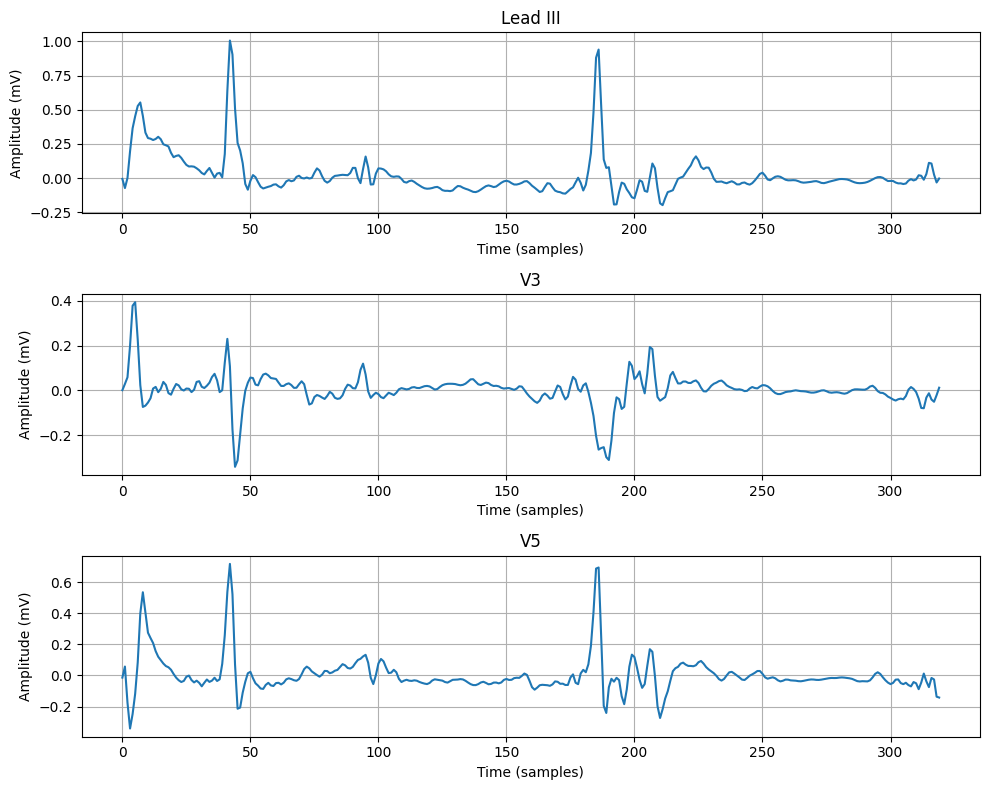

In [ ]:
if os.path.exists("fine_tune_data.npy"):
    data = np.load("fine_tune_data.npy", allow_pickle=True)
    segments = [item[0] for item in data]  # Collect segments from the saved data
    ecg_dataset = np.stack(segments)  # Stack all segments into a single array
    normalized_data, lead_mins, lead_maxs = per_lead_minmax_scaling(
        ecg_dataset=ecg_dataset)  # Normalize values in each lead between (-1,1)
outputs = []
for i in range(0,4):
    with torch.autograd.no_grad():
        dummy_input = torch.randn(1, 50, device=device)
        dummy_cond = torch.tensor(
            [i], device=device, dtype=torch.long).unsqueeze(1)
        output = cgen(dummy_input, dummy_cond)
        output_ = output.cpu().numpy()
        output_ = per_lead_inverse_scaling(output_, lead_mins, lead_maxs)
        outputs.append(output_)
plot_generated_sample(output,lead_mins,lead_maxs)

In [ ]:
summary(cgen, input_data=(torch.randn(1,50,device=device), dummy_cond), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 640, 3]               --
├─Embedding: 1-1                         [1, 1]                    4
├─Linear: 1-2                            [1, 20480]                1,064,960
├─Sequential: 1-3                        [1, 128, 640]             --
│    └─Conv1d: 2-1                       [1, 64, 640]              14,400
│    └─ReLU: 2-2                         [1, 64, 640]              --
│    └─Conv1d: 2-3                       [1, 128, 640]             57,472
│    └─ReLU: 2-4                         [1, 128, 640]             --
├─LSTM: 1-4                              [1, 640, 100]             72,000
├─LayerNorm: 1-5                         [1, 640, 100]             200
├─LSTM: 1-6                              [1, 640, 100]             60,800
├─LayerNorm: 1-7                         [1, 640, 100]             (recursive)
├─Sequential: 1-8                        [1, 3, 640] 

In [ ]:
critic = Critic(640,3,1)
critic.load_state_dict(CWGAN_metrics['critic_state_dict'])
critic.eval()
critic.to(device)

Critic(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(2,), padding=(4,))
  (conv2): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (conv3): Conv1d(128, 256, kernel_size=(9,), stride=(2,), padding=(2,))
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (condition_embedding): Embedding(4, 1)
  (cond_fc): Linear(in_features=1, out_features=50, bias=True)
  (mb_discrim): MiniBatchDiscrimination()
  (fc): Linear(in_features=20374, out_features=1, bias=True)
)

In [ ]:
summary(critic, input_data=(output,dummy_cond), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
Critic                                   [1, 1]                    --
├─Embedding: 1-1                         [1, 1]                    4
├─Linear: 1-2                            [1, 50]                   100
├─Conv1d: 1-3                            [1, 64, 322]              1,024
├─LeakyReLU: 1-4                         [1, 64, 322]              --
├─Conv1d: 1-5                            [1, 128, 161]             57,472
├─LeakyReLU: 1-6                         [1, 128, 161]             --
├─Conv1d: 1-7                            [1, 256, 79]              295,168
├─LeakyReLU: 1-8                         [1, 256, 79]              --
├─MiniBatchDiscrimination: 1-9           [1, 20324]                10,112,000
├─Linear: 1-10                           [1, 1]                    20,375
Total params: 10,486,143
Trainable params: 10,486,143
Non-trainable params: 0
Total mult-adds (M): 93.09
Input size (MB): 0.01
Forw

In [ ]:
metrics = CWGAN_metrics['metrics_history']
print(metrics['gen_loss'])
print(metrics['mvdtw'])

[59.29161911919003, 12.848868559277246, 12.110484486534482, 8.637644256864276, 8.086582013538905, 7.806226908214509, 7.672186068126133, 7.628651944417802, 5.846771923322526, 4.904191950010875, 4.960395918952094, 4.868867384062873, 4.758731088941059, 4.768701952601236, 4.777616076999241, 4.950460267445398, 3.302927022888547, 2.7265985135048156, 2.447610298792521, 1.9085586648138742, 1.4231736168028817, 1.0385705648906647, 0.5400077757381258, 0.23376802981845915, -0.26641689406500924, -0.4458247877302624, -0.3819104376293364, -0.2846803854382227, -0.2813241519625225, -0.18818185253748818, -0.10794711680639357, -0.027686285594153027, -0.014604303571912978, 0.05199541932060605, -0.02614751694694398, 0.033182732642643036, 0.24971986763061038, 0.4089870301503984, 0.3367055408538334, 0.4483352237277561, 0.4197748539939759, 0.6891568776160951, 0.5920393419644189, 0.921883984217568, 1.2622356386411757, 1.3799722885328627, 1.429838668732416, 1.4103538469662742, 1.400855557313041, 1.4297227679737

In [ ]:
import pandas as pd
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
df = pd.read_csv("augmented_dataset.csv")
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)
TVAE_model = TVAESynthesizer(
    metadata=metadata, epochs=3000, cuda=True, verbose=True)
model = TVAE_model.load("TVAE_model.pkl")
synth_crf_df = model.sample(16104)
condition_mapping = {
        'none': 0,
        'myocardial infarction': 1,
        'stroke': 2,
        'syncope': 3
    }
synth_crf_df['Vascular event'] = synth_crf_df['Vascular event'].str.lower().map(
        condition_mapping)
synth_crf = synth_crf_df.to_numpy()

/home/elukbog/Projects/MEng-Project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/home/elukbog/Projects/MEng-Project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [ ]:
[synth_crf[0][:7]]

[array([-1.04243195,  1.12892122,  1.08743364, -0.9508149 , -0.84300192,
         0.        ,  0.        ])]

In [ ]:
synth_crf[0][7]

np.float64(3.0)

In [ ]:
from gan_scripts.ECG_classifier import Classifier
classifier = Classifier(640,7,4)
# classifier()
crfs = torch.tensor(np.array([synth_crf[0][:7]]),dtype=torch.float32)
summary(classifier,input_data=(output.permute(0,2,1),torch.tensor([synth_crf[0][:7]],dtype=torch.float32)),device="cuda")

/tmp/ipykernel_1338308/3097227795.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  summary(classifier,input_data=(output.permute(0,2,1),torch.tensor([synth_crf[0][:7]],dtype=torch.float32)),device="cuda")


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 4]                    --
├─Sequential: 1-1                        [1, 256, 1]               --
│    └─Conv1d: 2-1                       [1, 64, 640]              1,024
│    └─BatchNorm1d: 2-2                  [1, 64, 640]              128
│    └─LeakyReLU: 2-3                    [1, 64, 640]              --
│    └─MaxPool1d: 2-4                    [1, 64, 320]              --
│    └─Conv1d: 2-5                       [1, 128, 318]             57,472
│    └─BatchNorm1d: 2-6                  [1, 128, 318]             256
│    └─LeakyReLU: 2-7                    [1, 128, 318]             --
│    └─MaxPool1d: 2-8                    [1, 128, 159]             --
│    └─Conv1d: 2-9                       [1, 256, 155]             295,168
│    └─BatchNorm1d: 2-10                 [1, 256, 155]             512
│    └─LeakyReLU: 2-11                   [1, 256, 155]             --


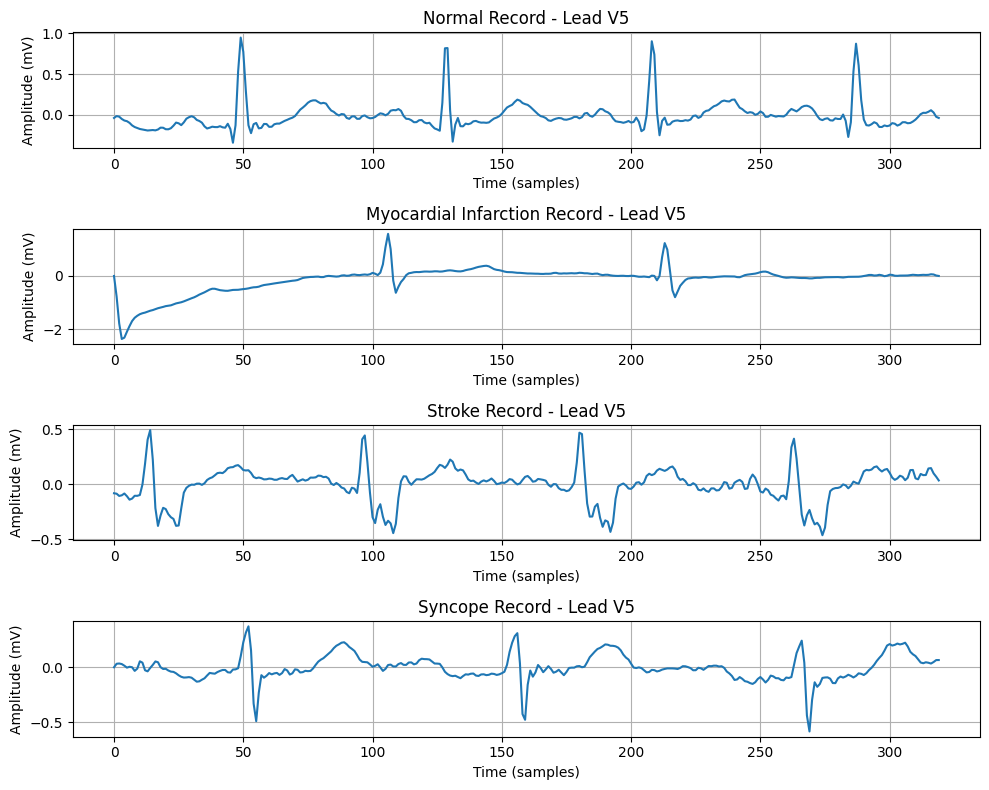

In [ ]:
classes = ['01911','02033','02119','02218']
class_names = ['Normal','Myocardial Infarction', 'Stroke', 'Syncope']
records = []
import wfdb
for class_ in classes:
    record = bandpass_filter(wfdb.rdrecord(f"data/dataset/{class_}", sampfrom=20000, sampto=20000+320).p_signal,0.5,40,128)
    records.append(record)
lead_labels = ['Lead III', 'V3', 'V5']
fig, axs = plt.subplots(4, 1, figsize=(10, 8))
for i, (record, ax) in enumerate(zip(records, axs)):
    ax.plot(record[:320, 2])  # Plot only the first lead
    ax.set_title(f"{class_names[i]} Record - Lead {lead_labels[2]}")
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Amplitude (mV)')
    ax.grid(True)
plt.tight_layout()
plt.show()

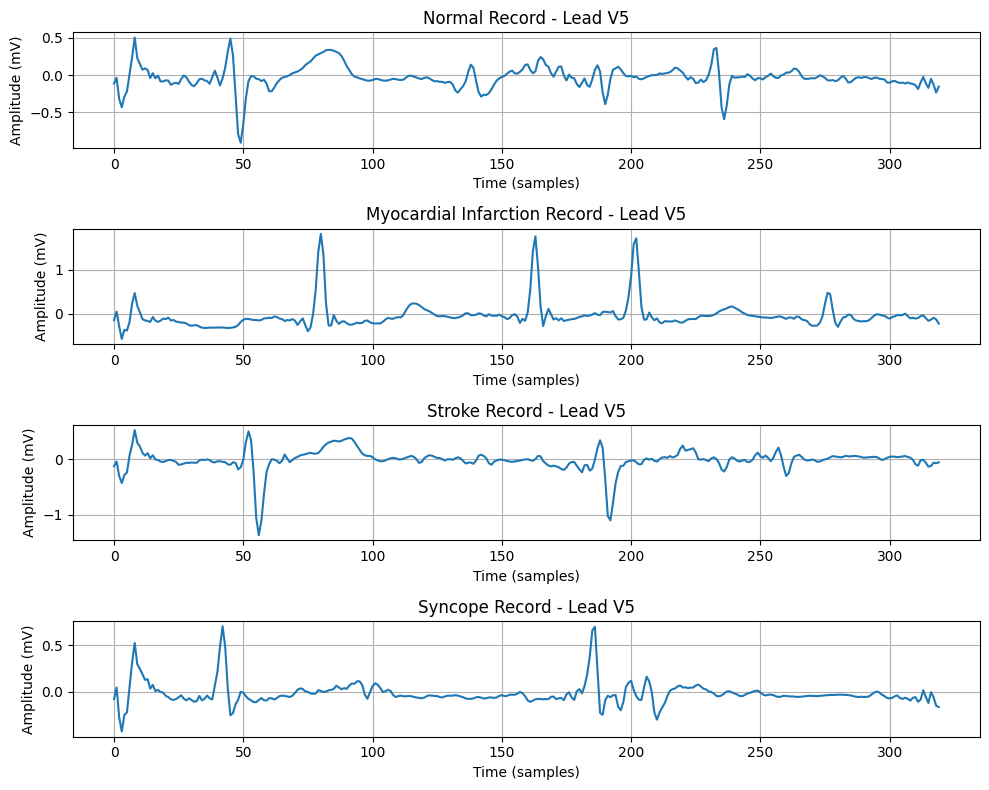

In [ ]:
lead_labels = ['Lead III', 'V3', 'V5']
fig, axs = plt.subplots(4, 1, figsize=(10, 8))
for i, (record, ax) in enumerate(zip(outputs, axs)):
    ax.plot(record[0][:320, 2])  # Plot only the first lead
    ax.set_title(f"{class_names[i]} Record - Lead {lead_labels[2]}")
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Amplitude (mV)')
    ax.grid(True)
plt.tight_layout()
plt.show()

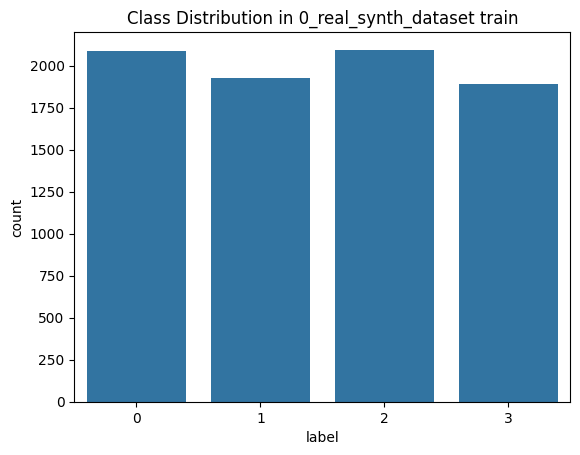

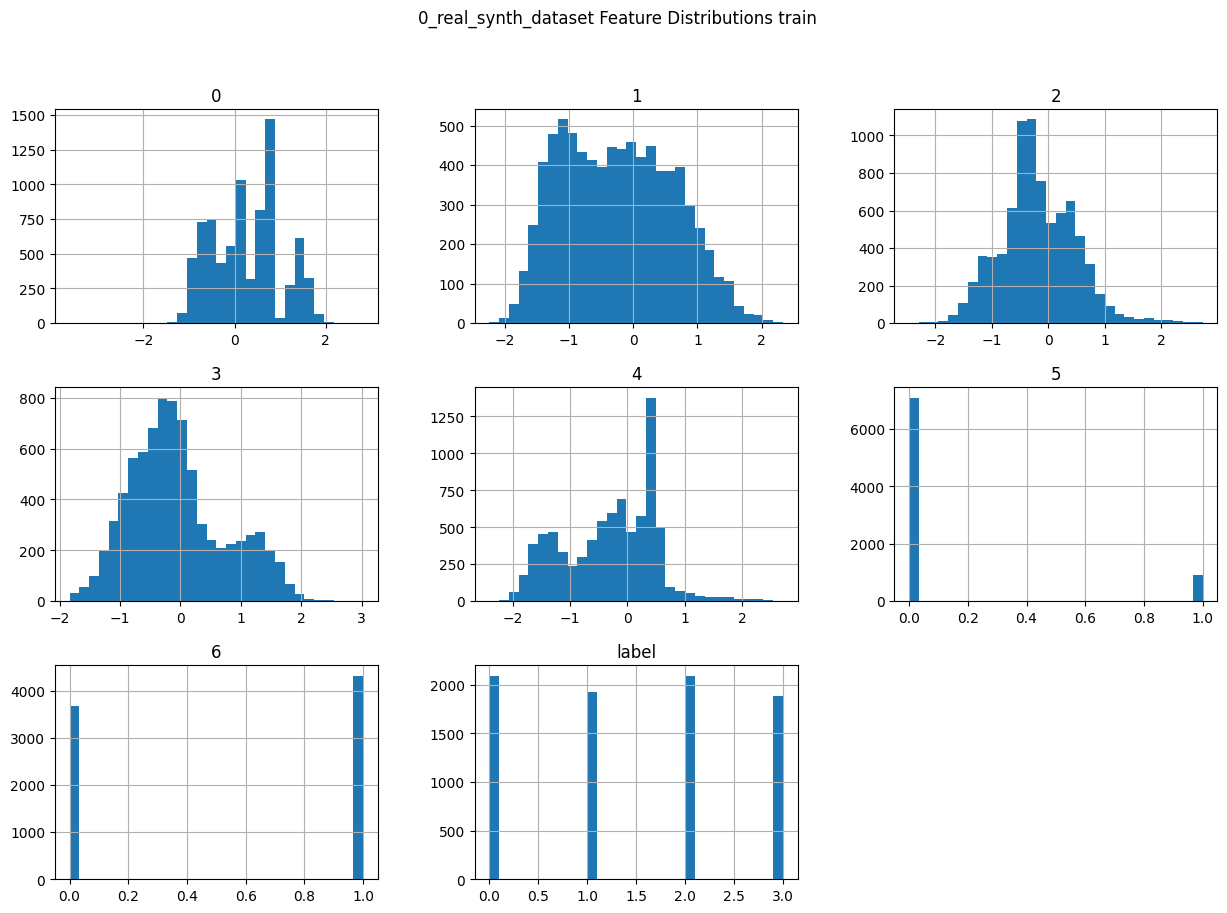

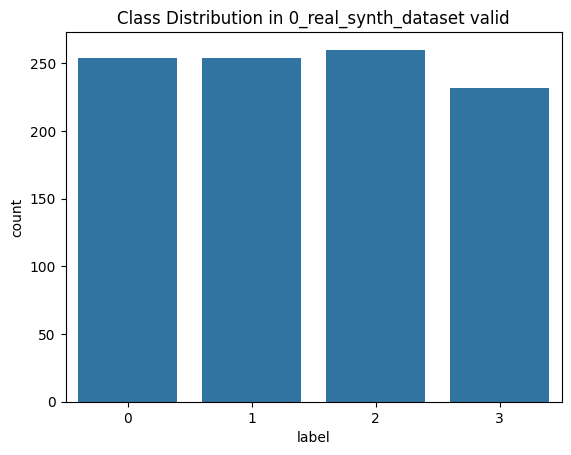

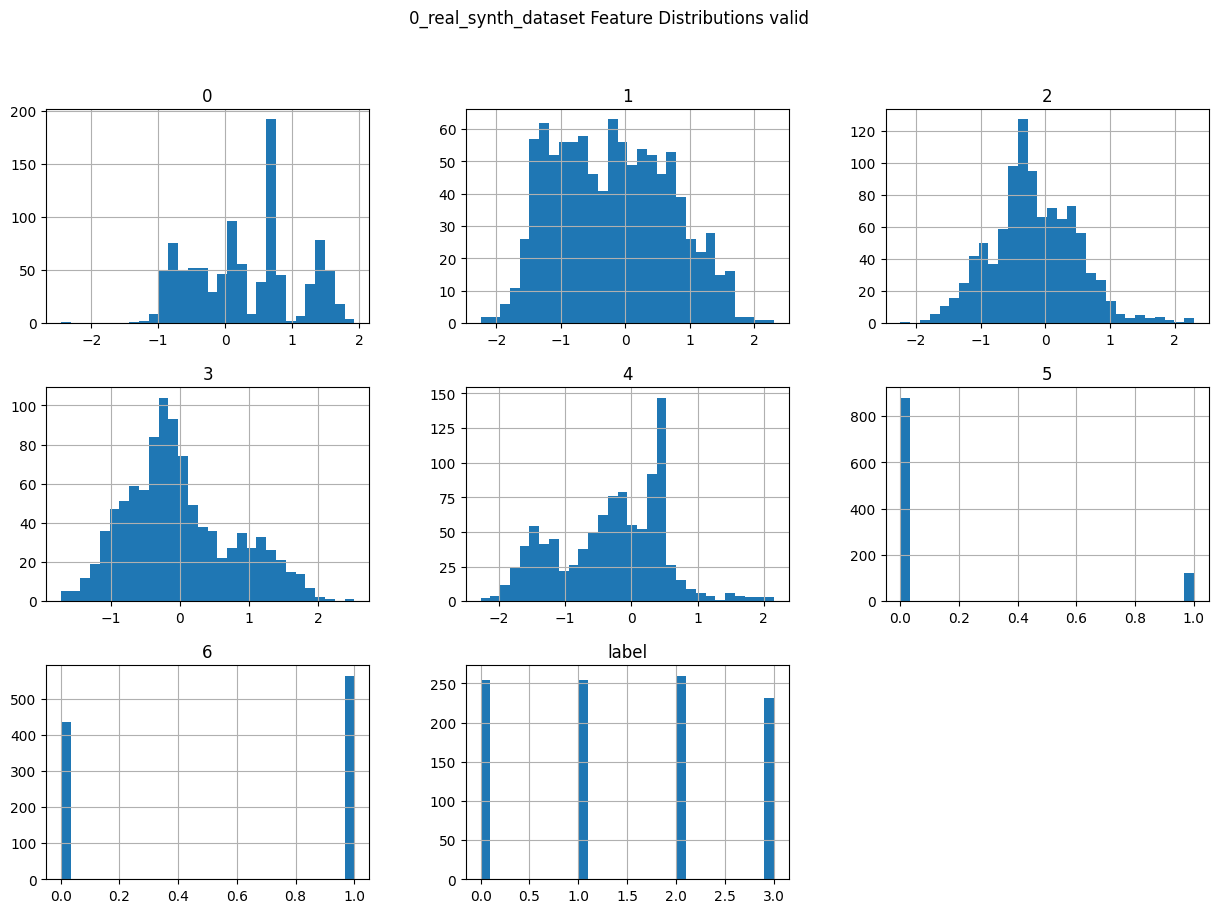

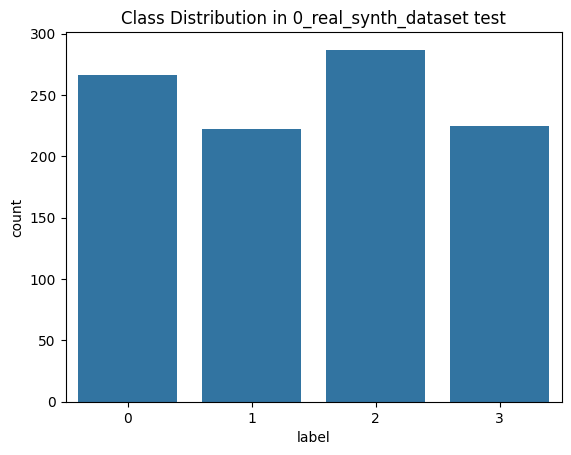

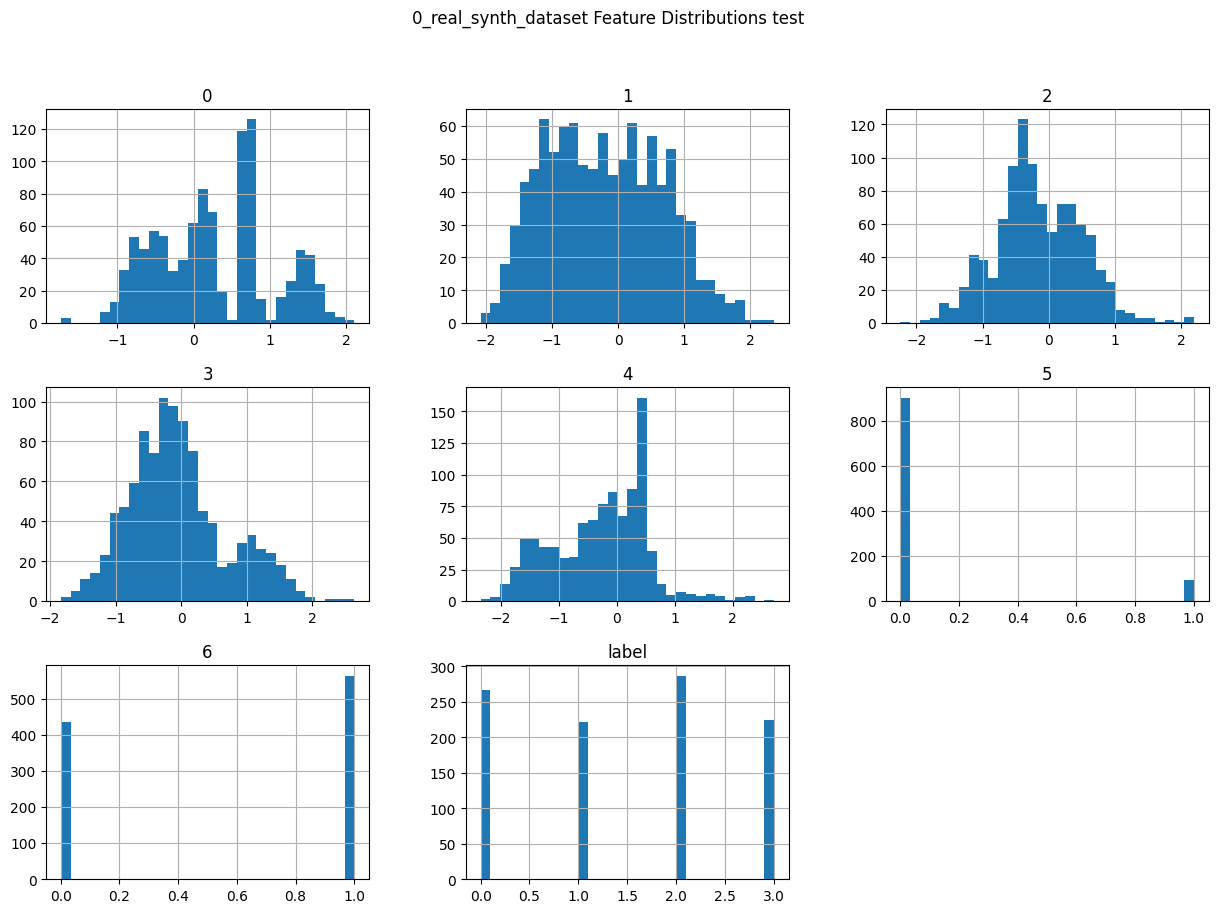

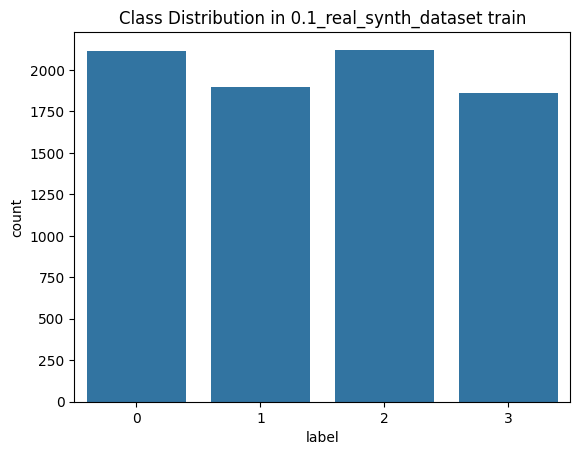

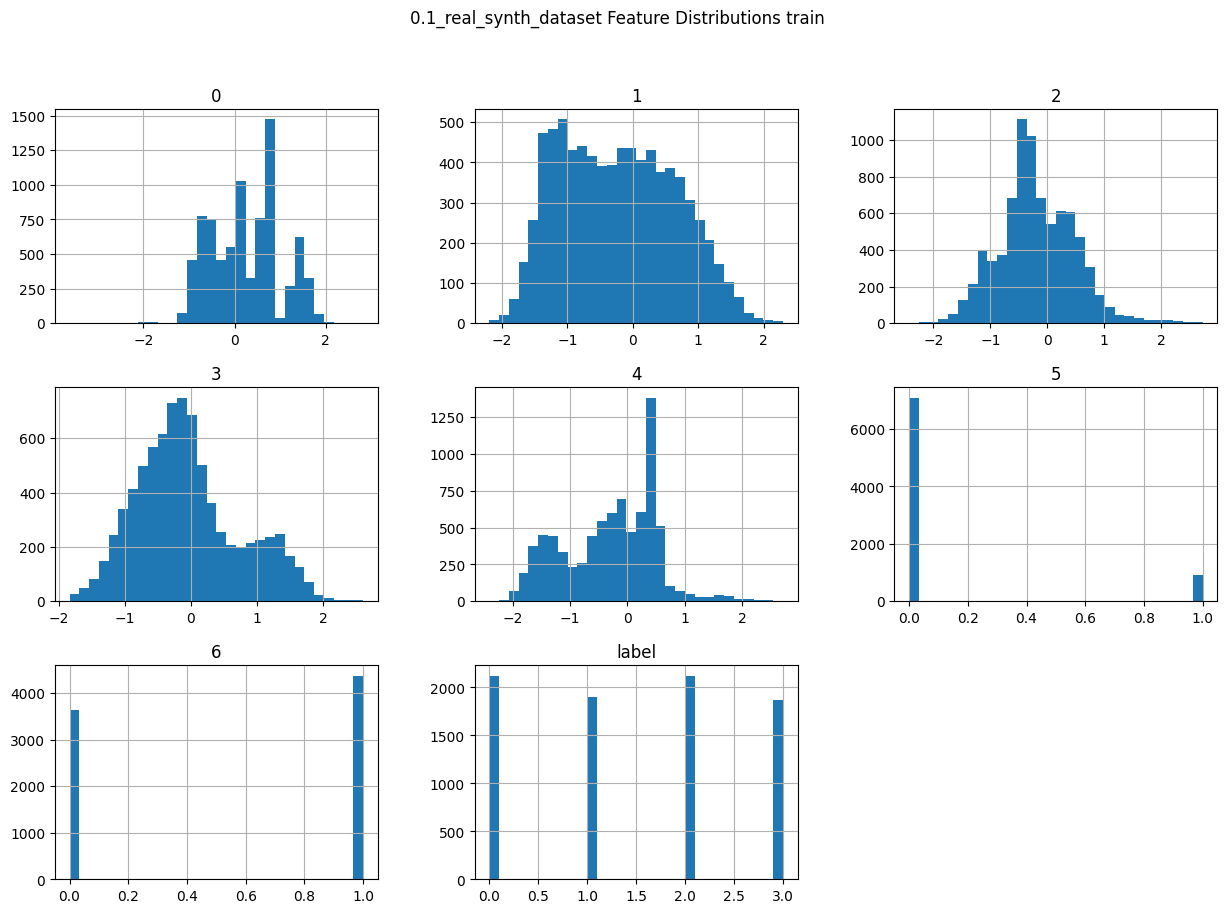

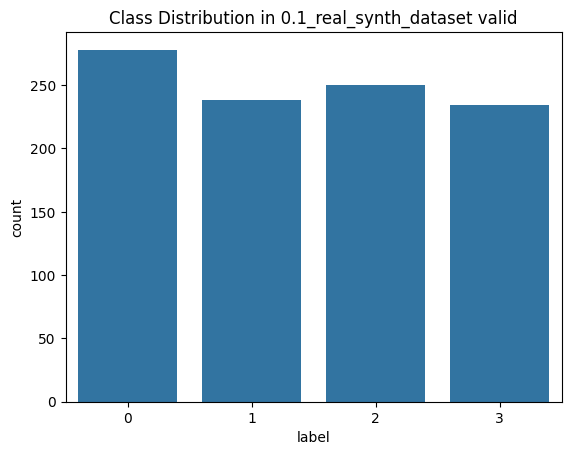

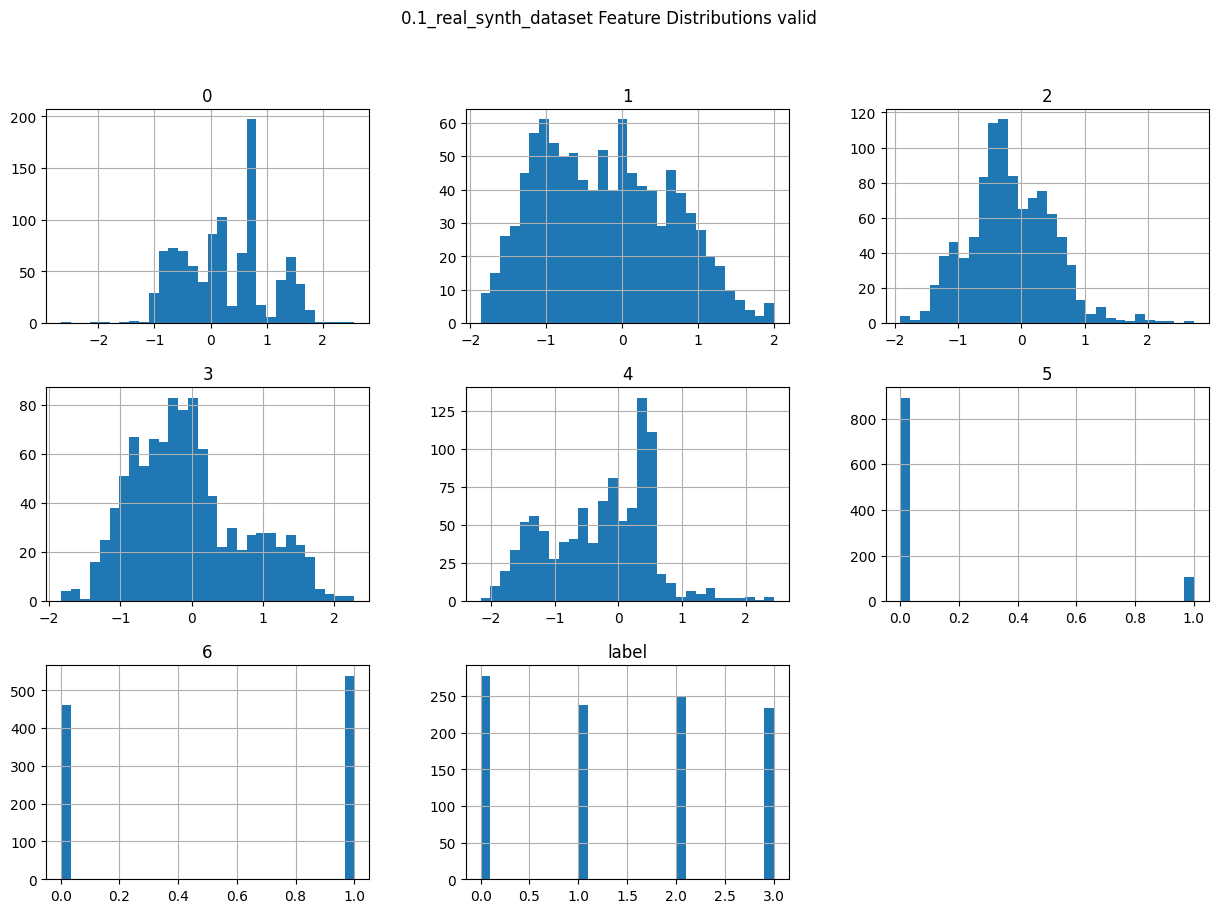

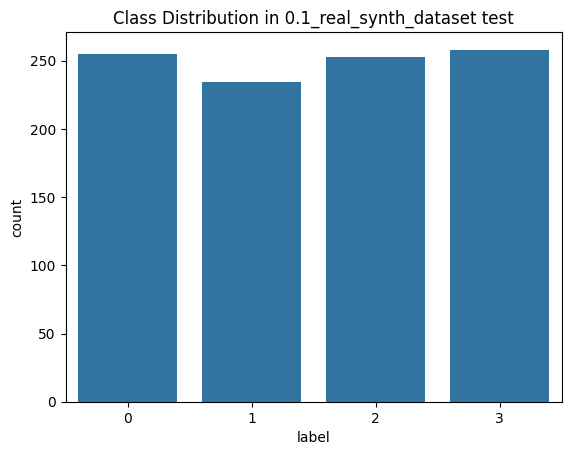

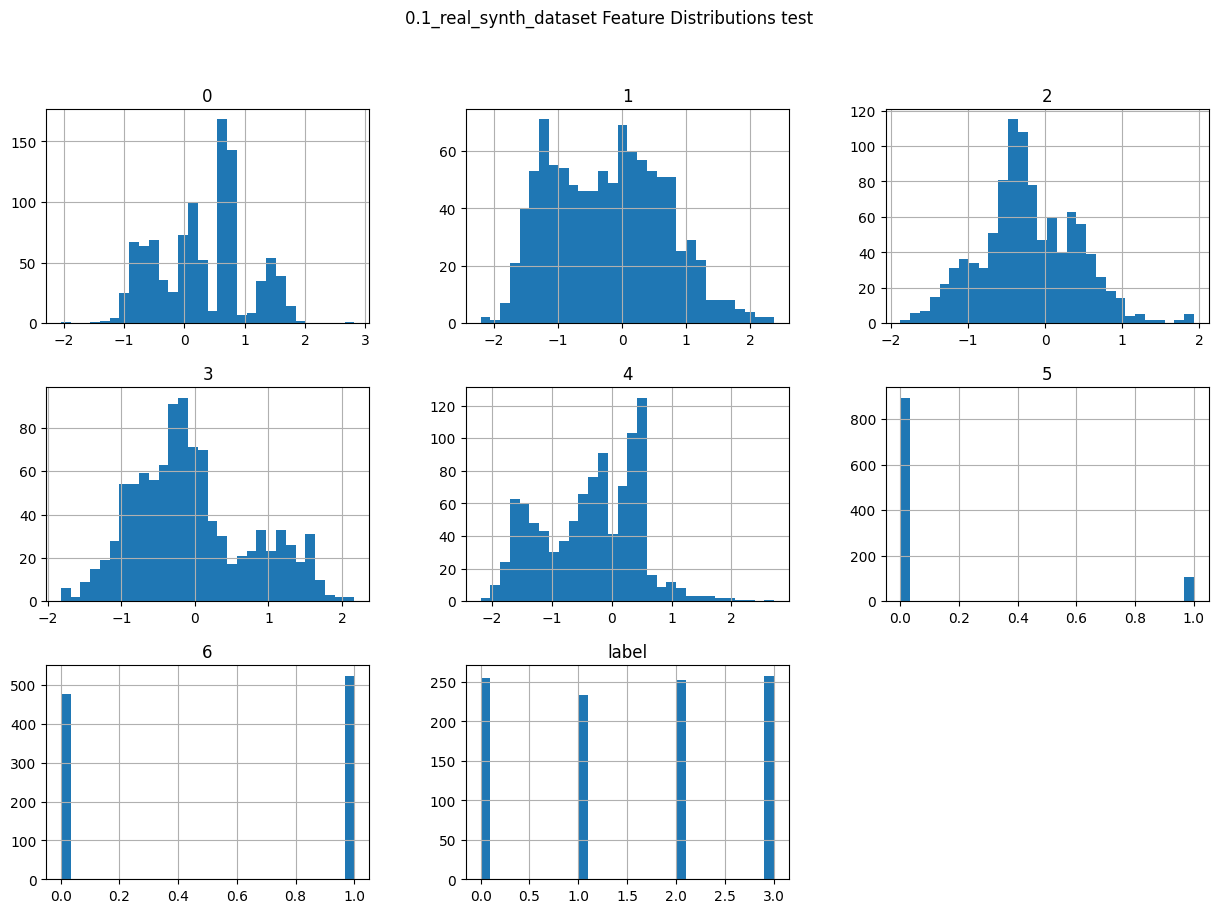

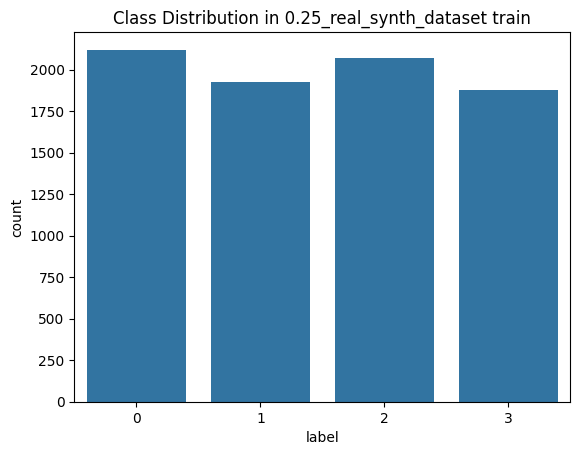

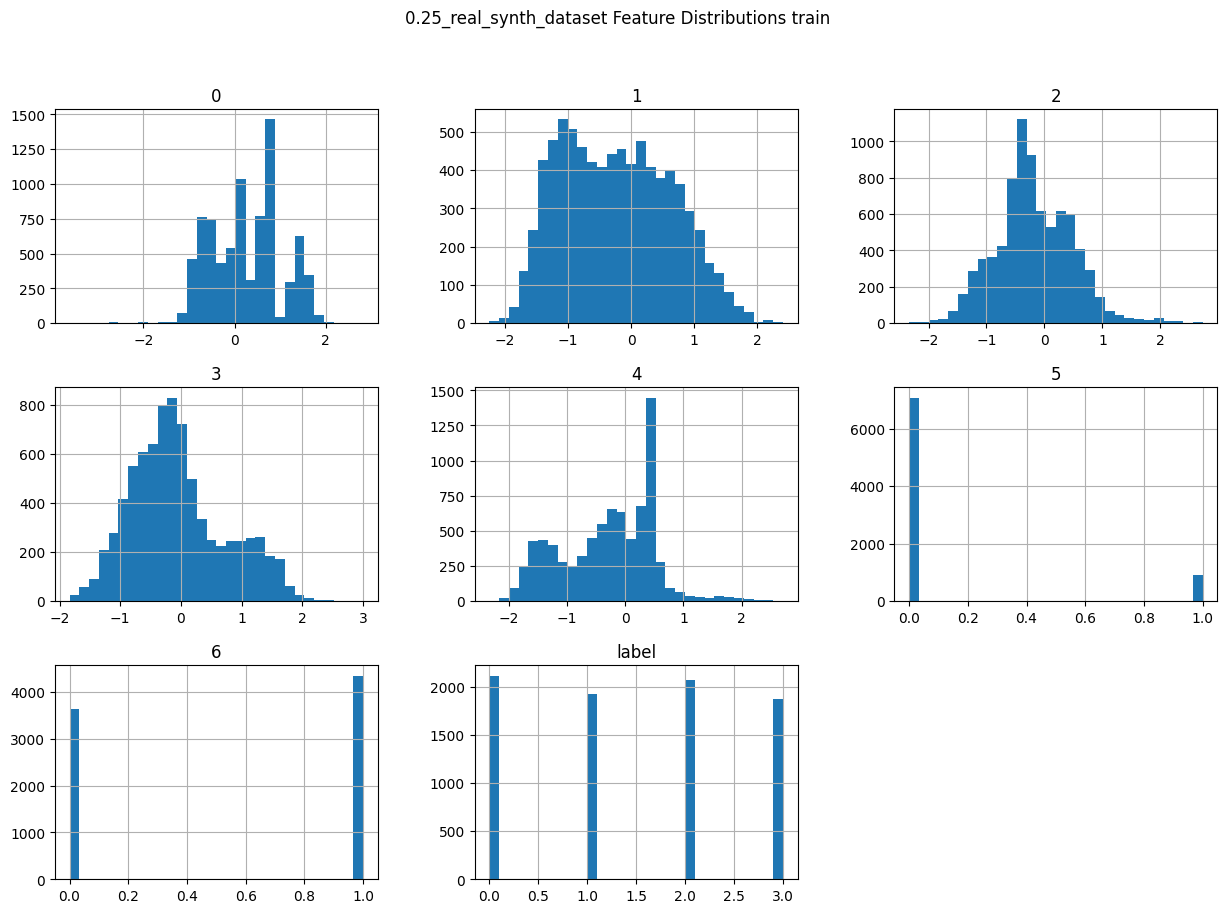

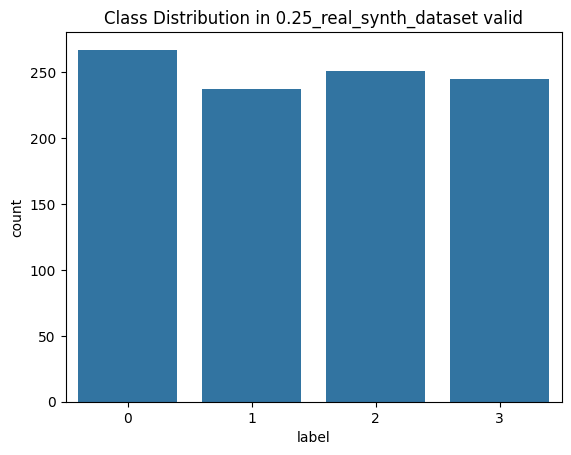

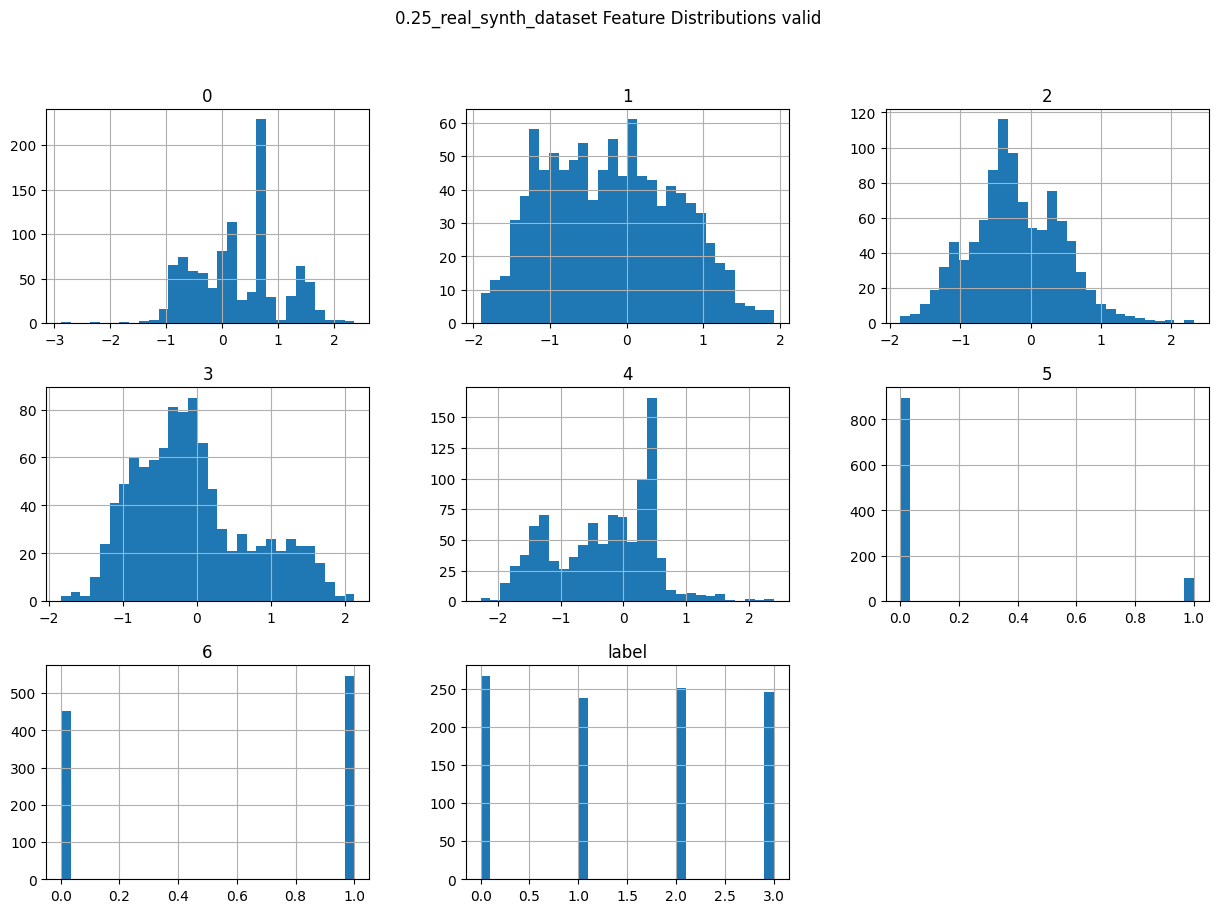

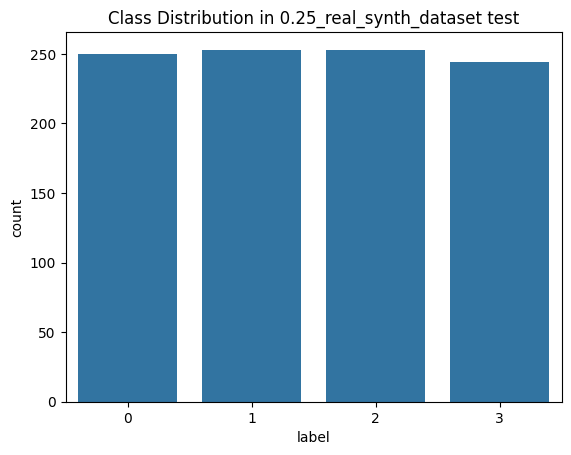

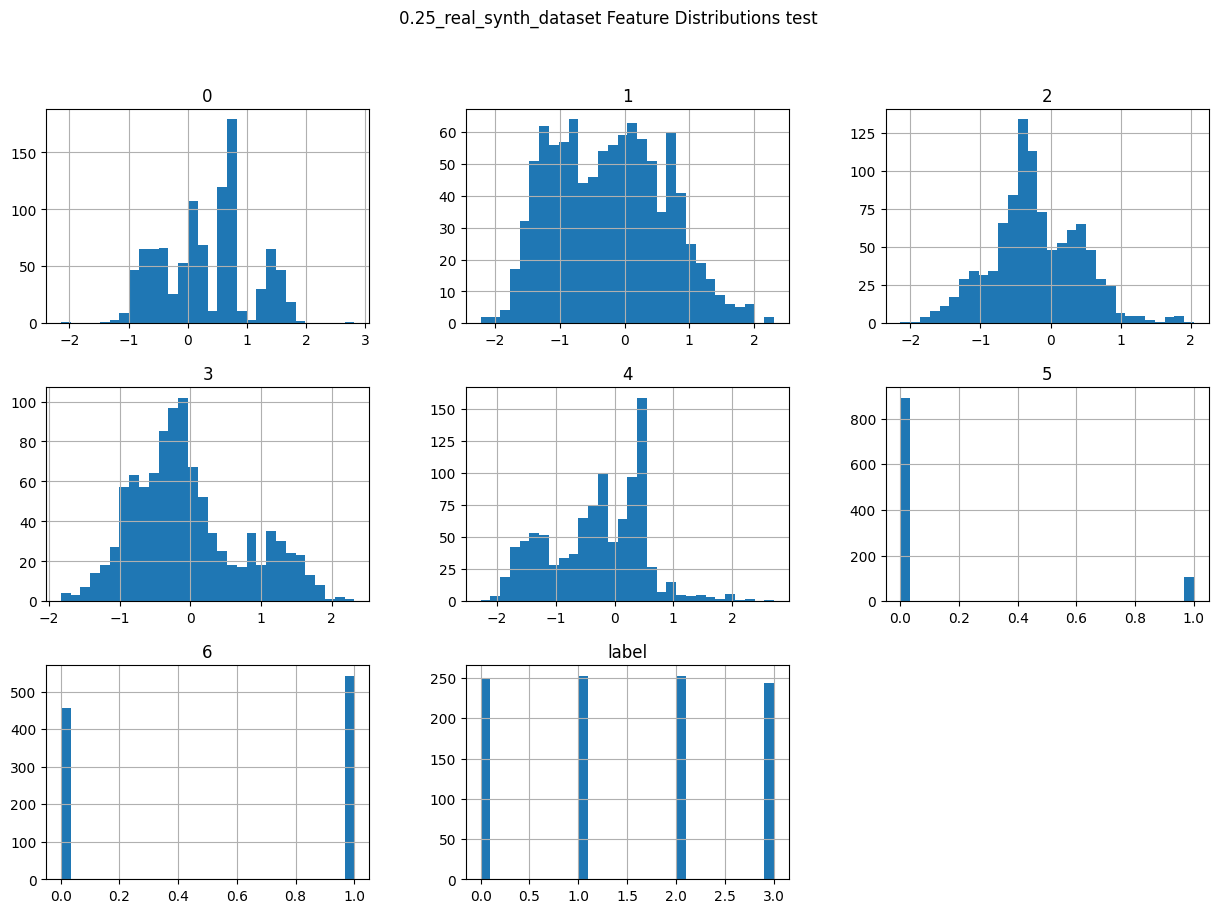

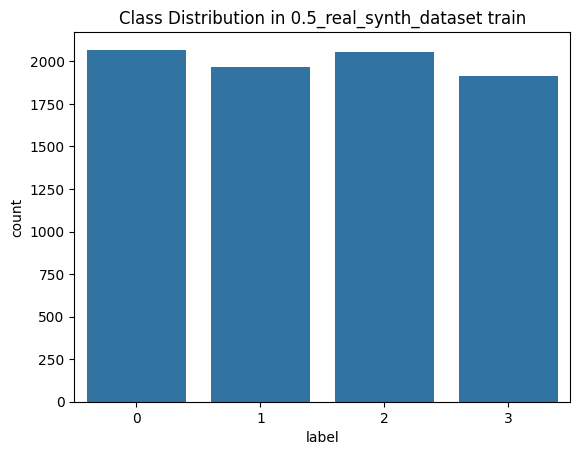

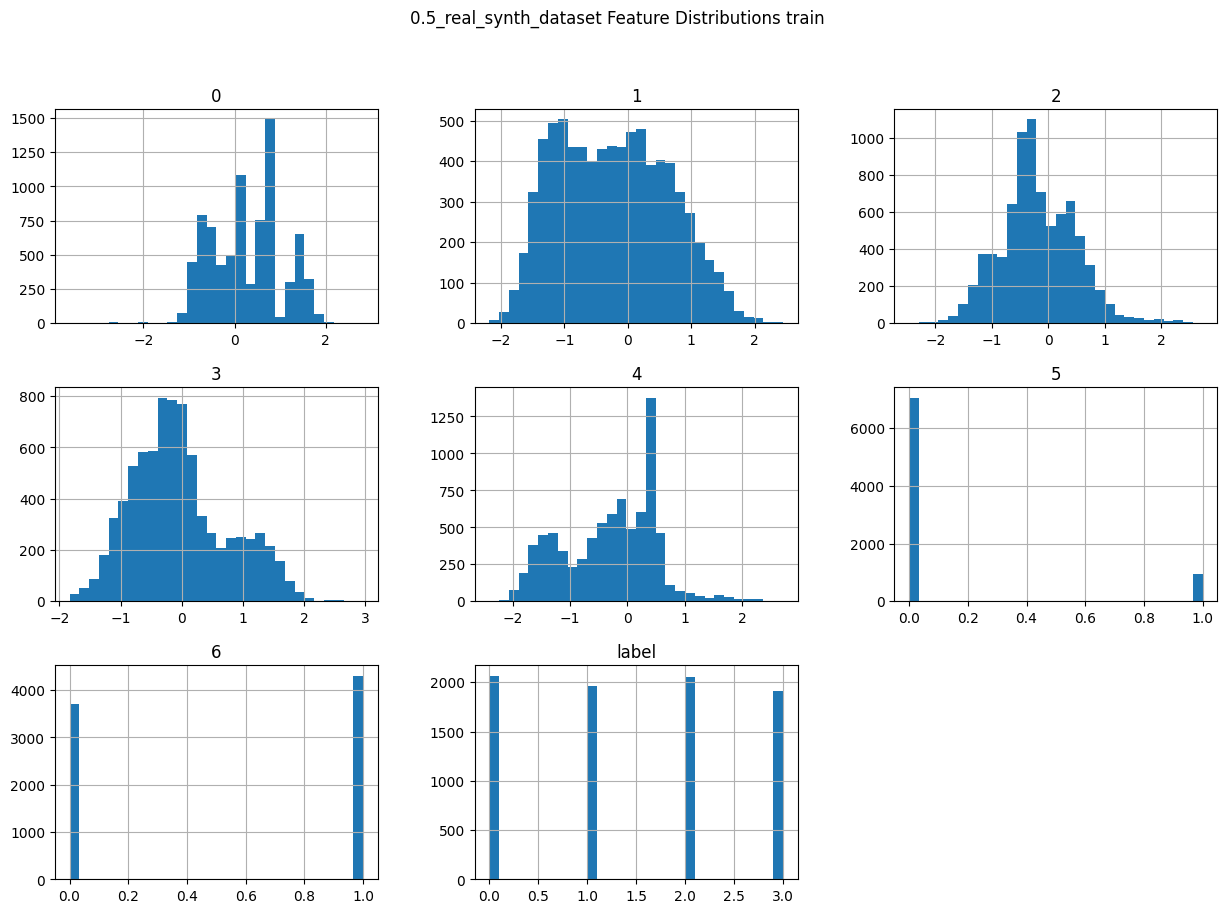

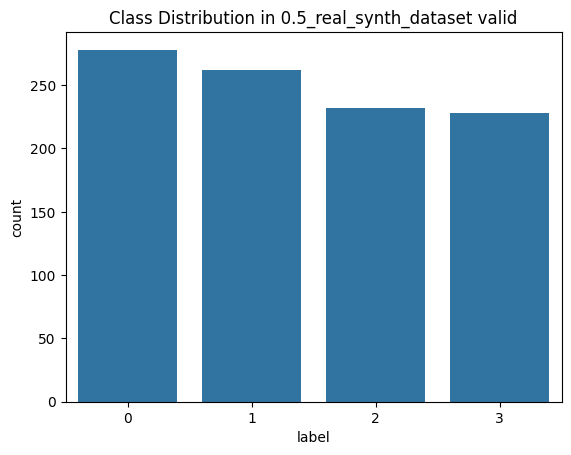

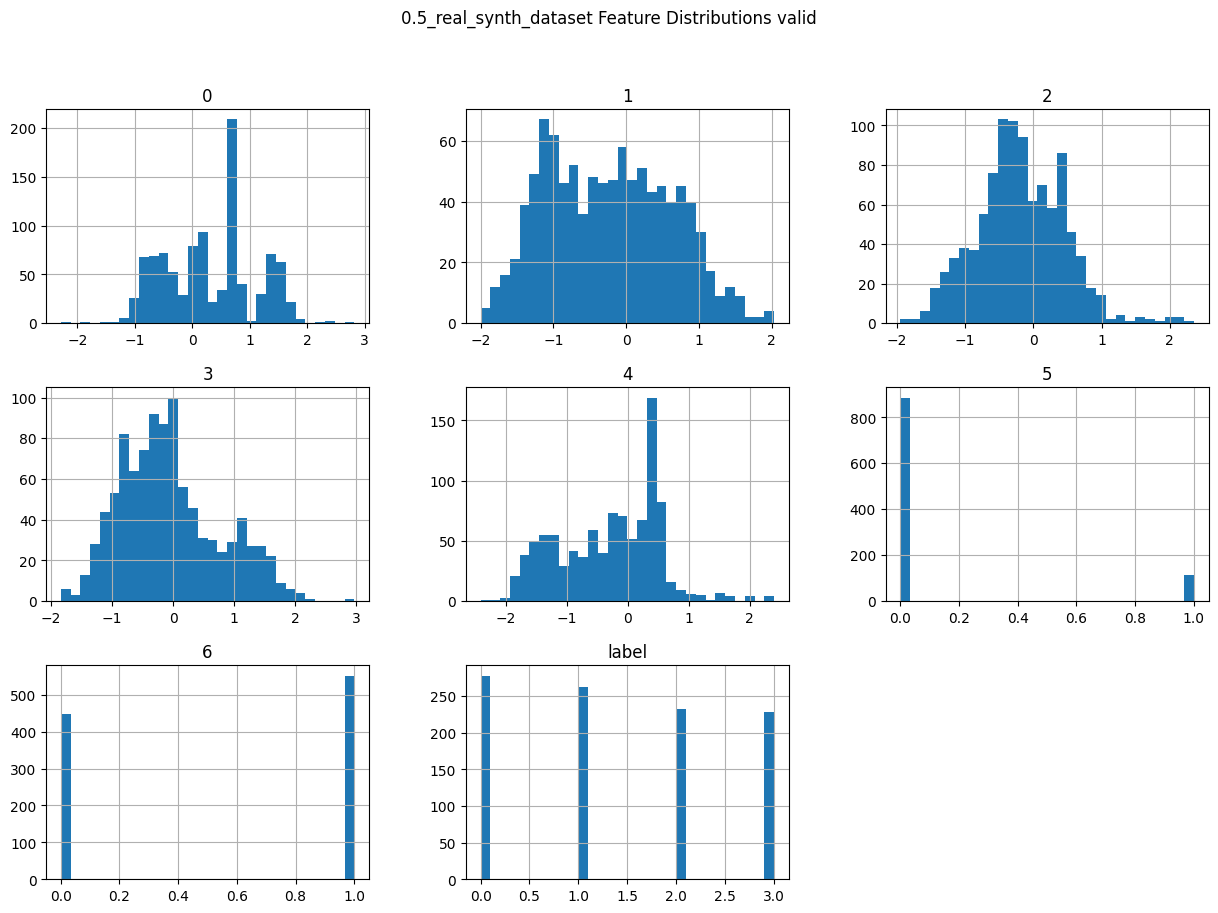

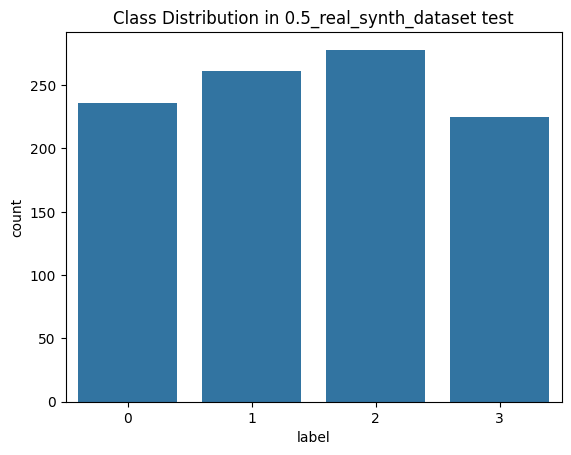

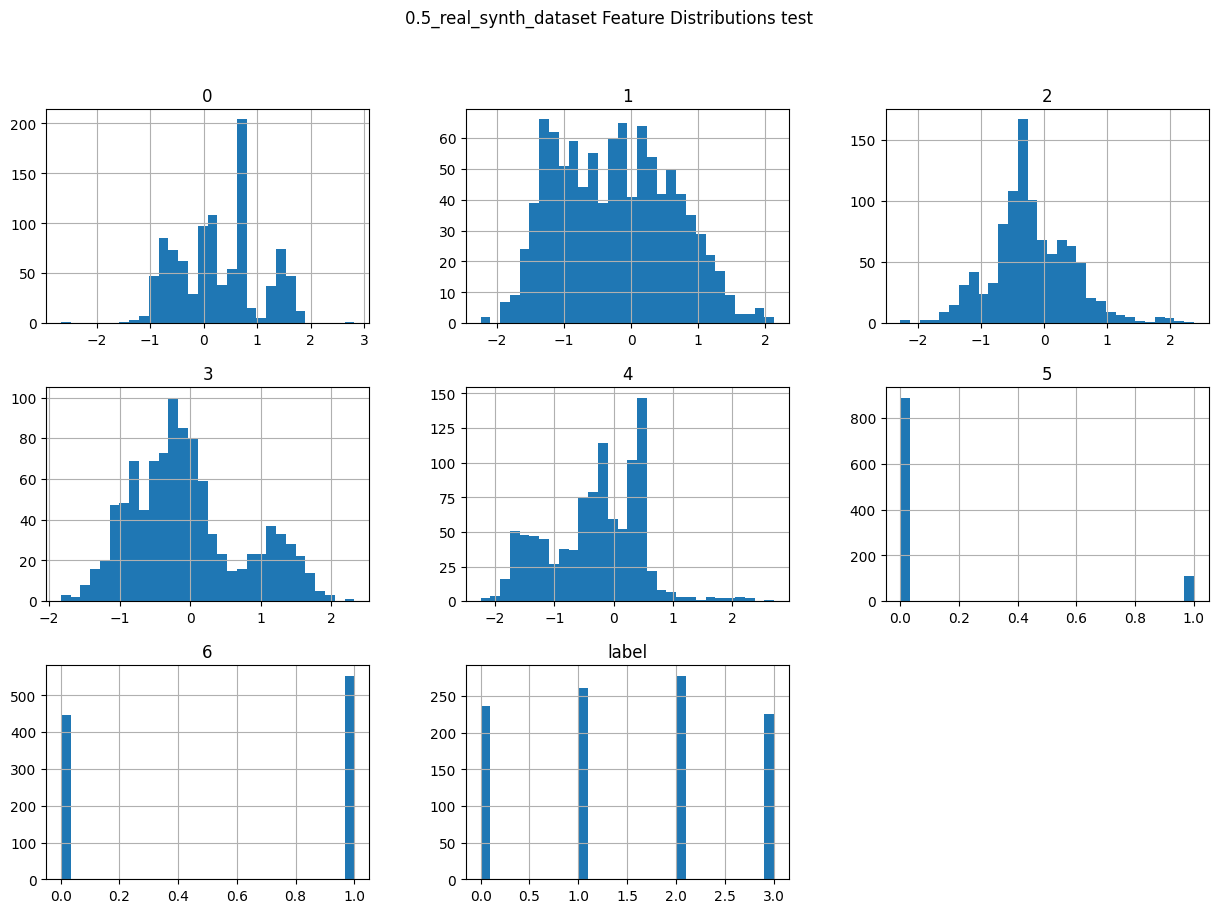

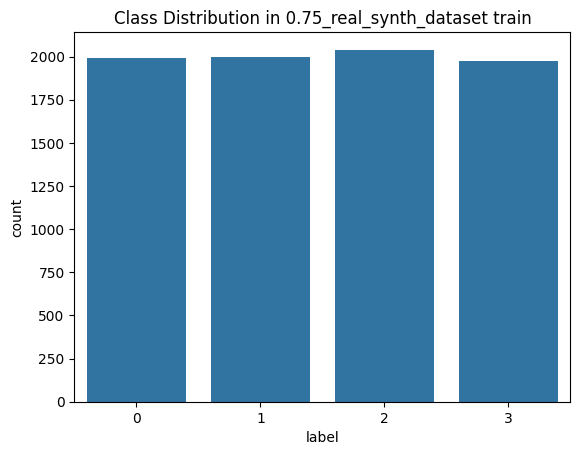

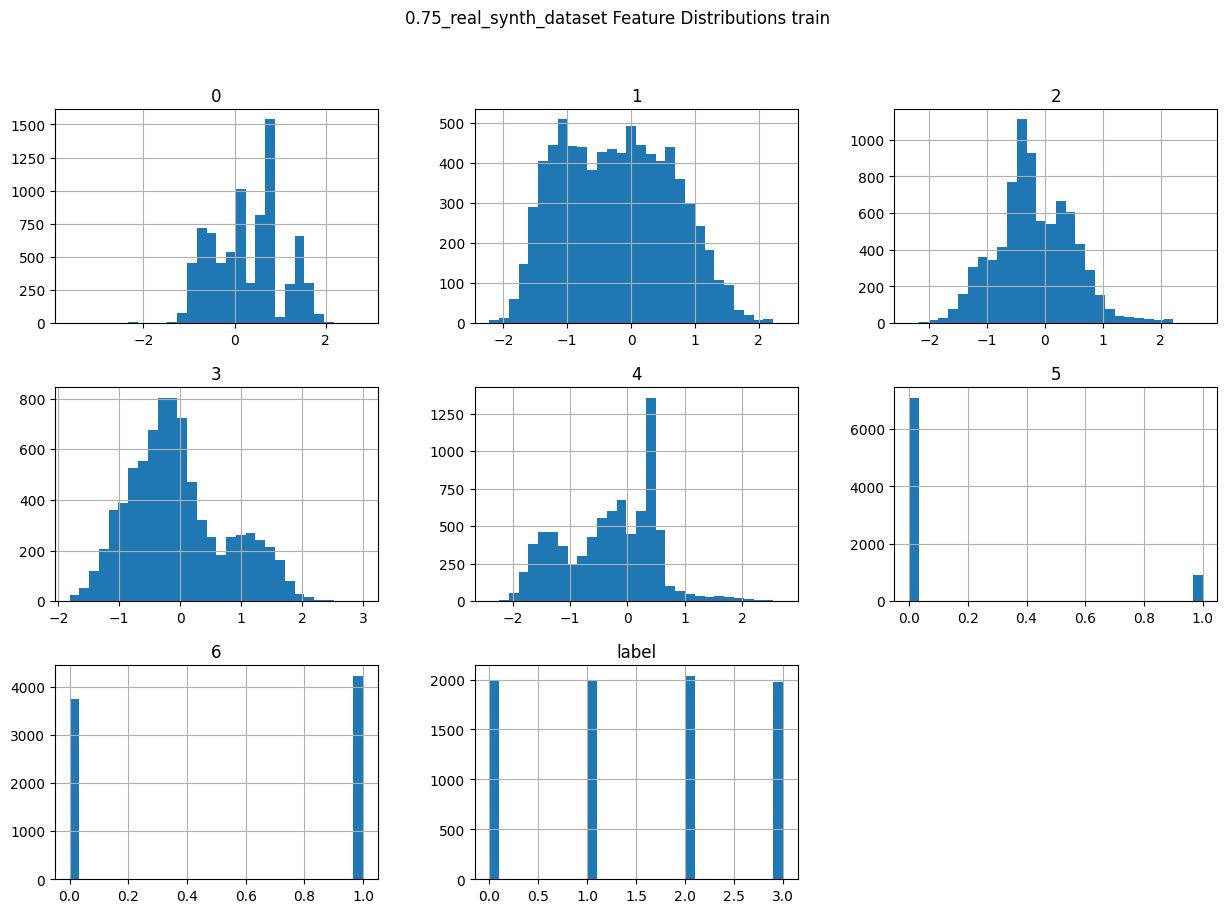

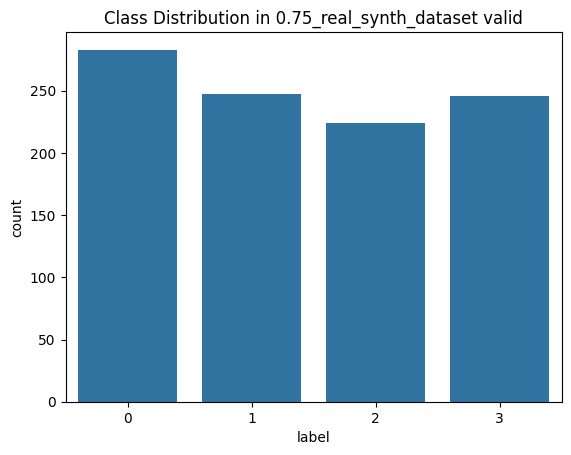

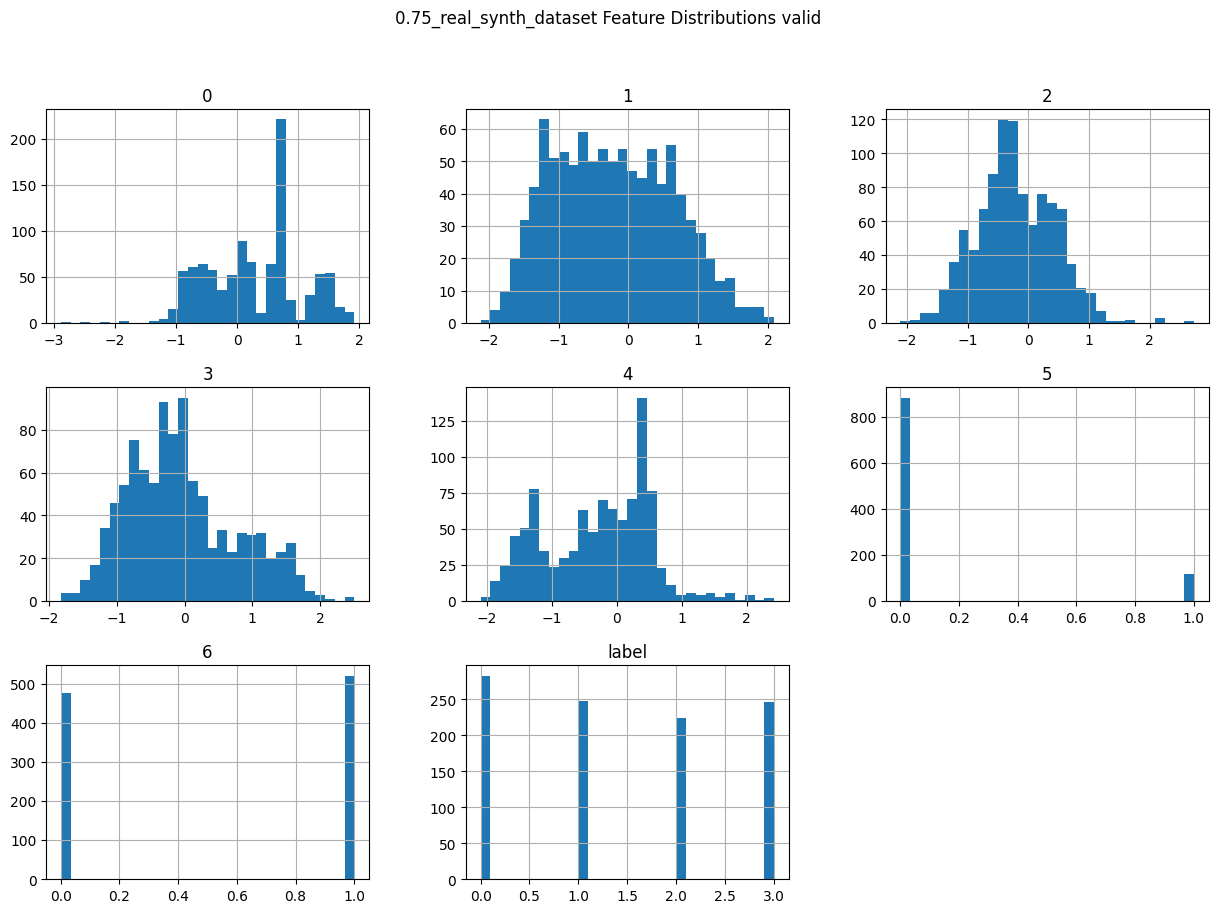

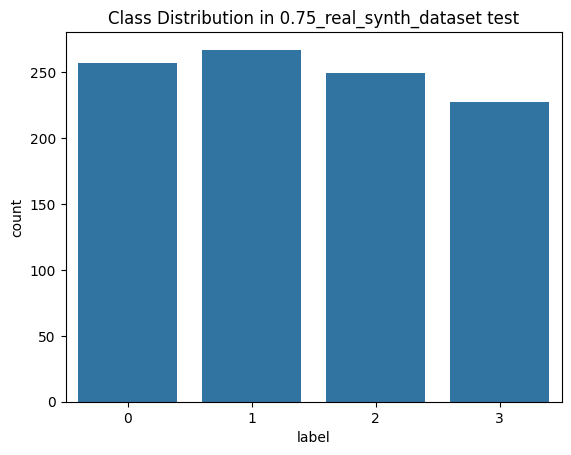

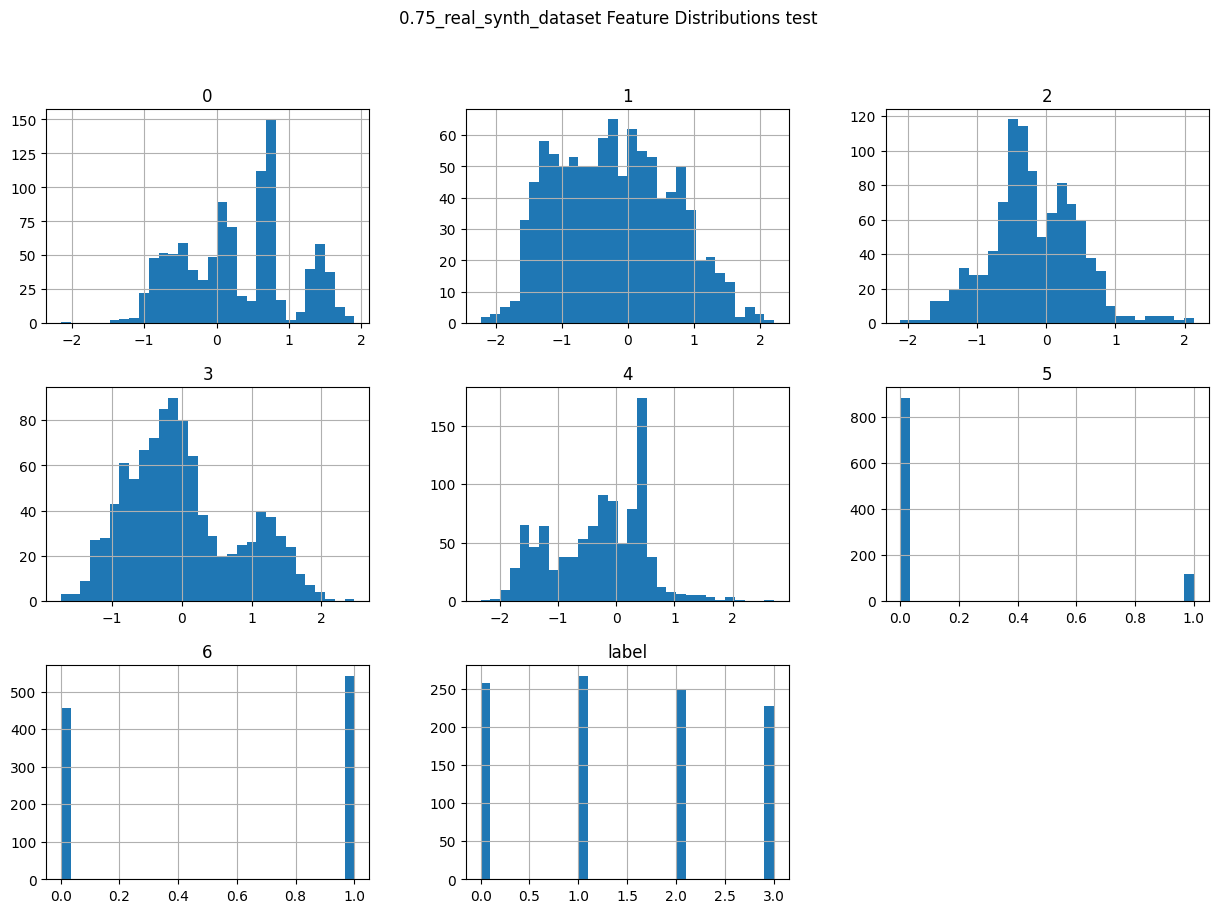

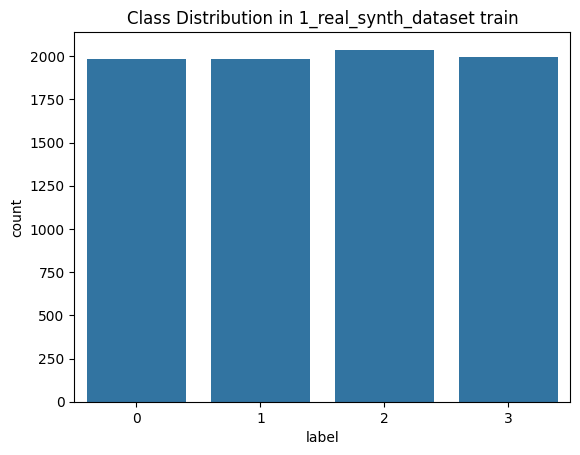

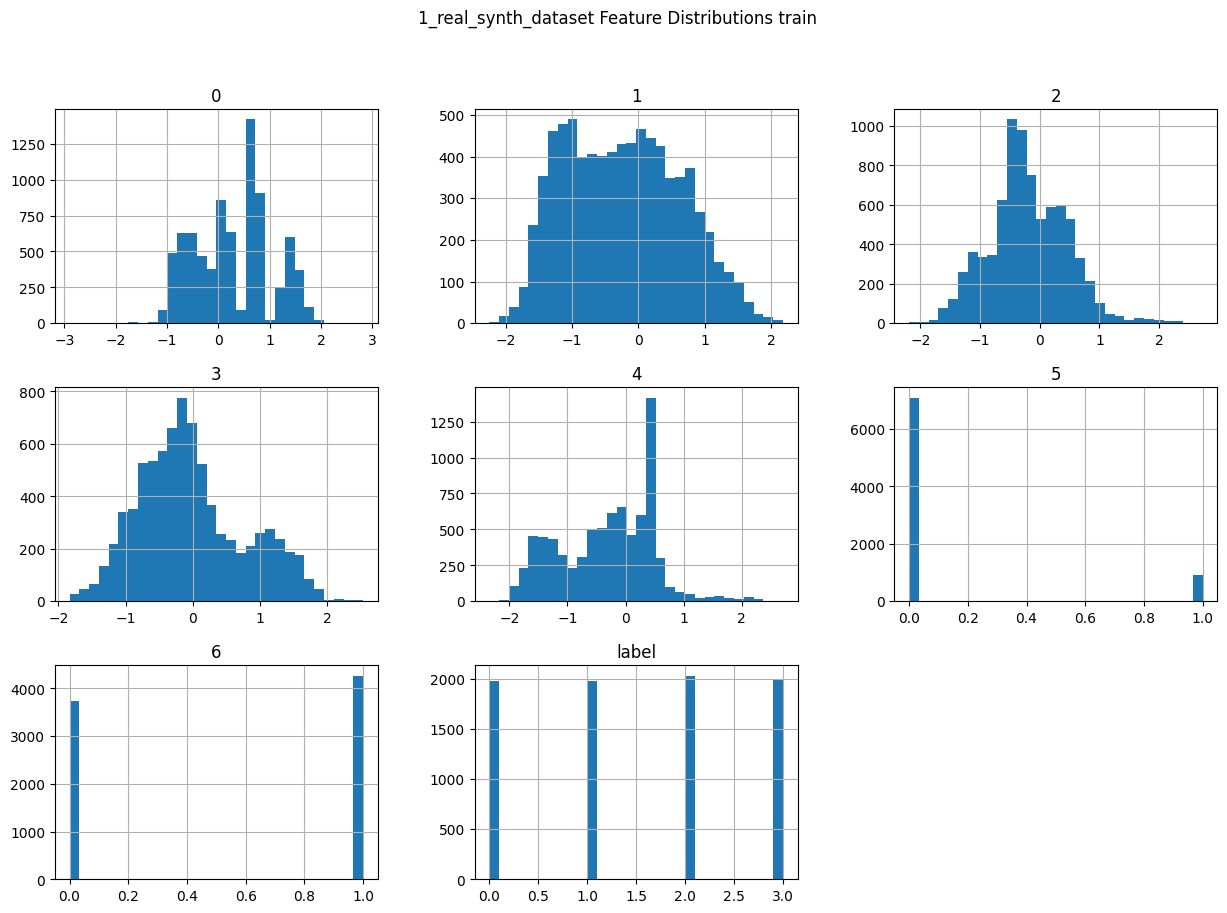

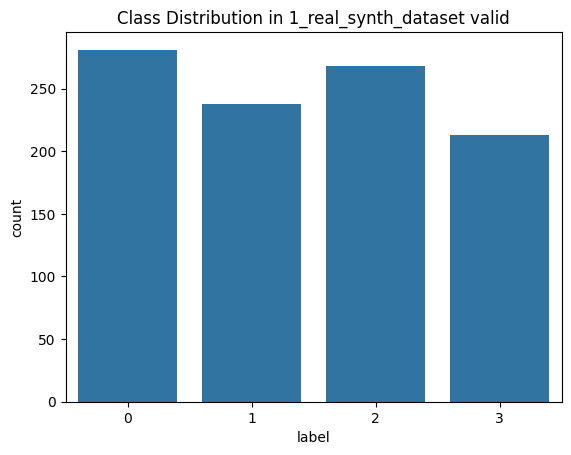

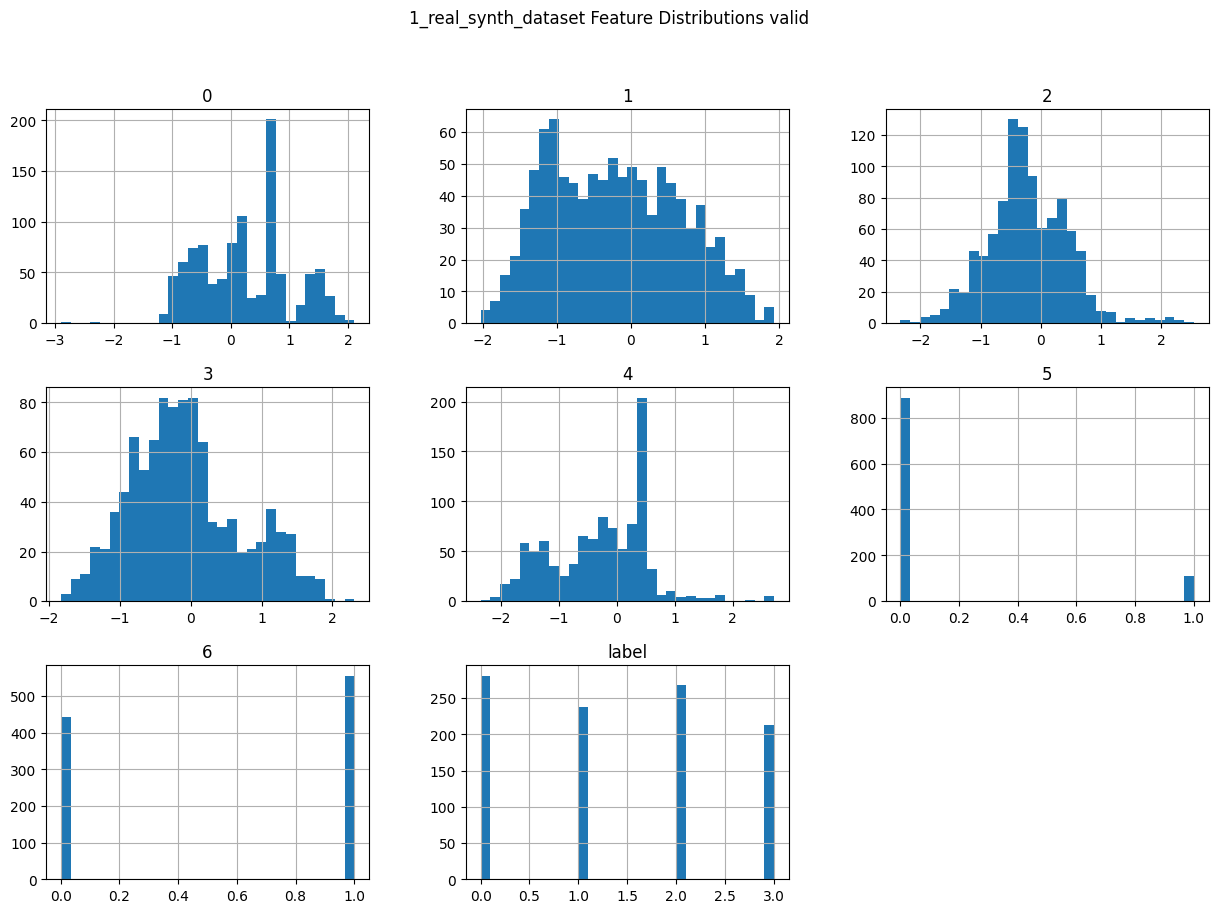

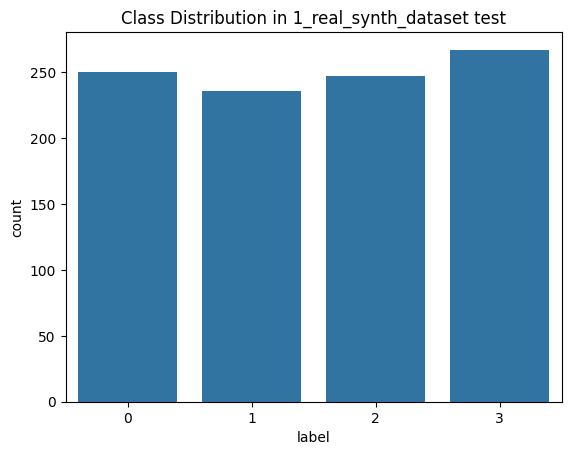

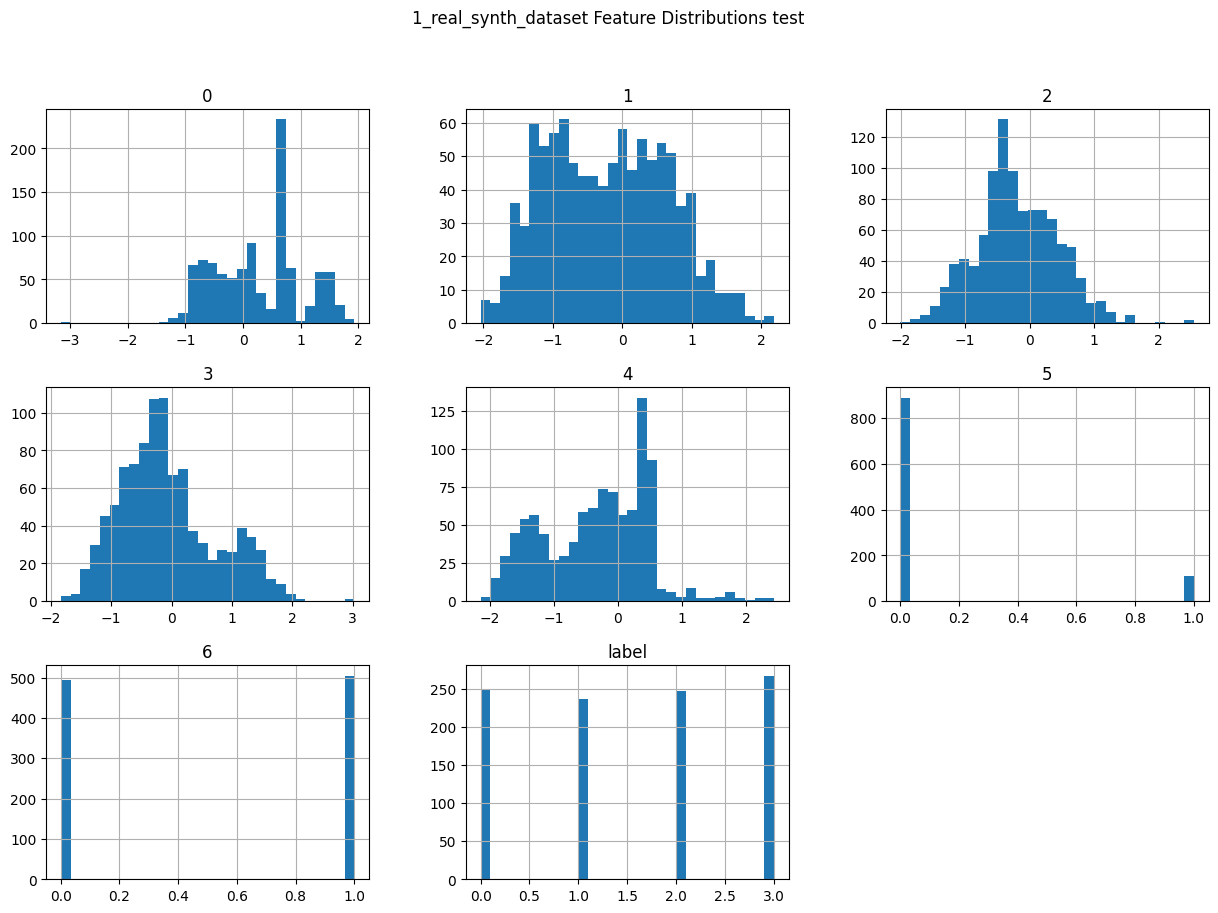

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def dataset_analysis(dataset):
    dataloader = torch.load(f"../synth_datasets/{dataset}_real_synth_dataset.pth", weights_only=False)
    sets = ['train','valid','test']
    for set in sets:
        all_y = []
        all_z = []
        for batch in dataloader[set]:
            _, y_batch, z_batch = batch
            all_y.append(y_batch)
            all_z.append(z_batch)
        y_tensor = torch.cat(all_y, dim=0)
        z_tensor = torch.cat(all_z, dim=0)
        y_np = y_tensor.numpy()
        z_np = z_tensor.numpy()
        df = pd.DataFrame(y_np)
        df['label'] = z_np
        sns.countplot(x=df['label'])
        plt.title(f"Class Distribution in {dataset}_real_synth_dataset {set}")
        plt.show()
        df.hist(figsize=(15, 10), bins=30)
        plt.suptitle(f"{dataset}_real_synth_dataset Feature Distributions {set}")
        plt.show()

dataset_analysis(0)
dataset_analysis(0.1)
dataset_analysis(0.25)
dataset_analysis(0.5)
dataset_analysis(0.75)
dataset_analysis(1)

In [47]:
import torch

def print_classifier_results():
    datasets = [0,0.5,1]
    i = 1
    for classifier in range(0,3):
        for dataset in datasets:
            try:
                metrics = torch.load(f"../classifier_models/classifier{classifier}/{dataset}_real_synth_data_classifier.pth", weights_only=False)
                metrics_history = metrics['metrics_history']
                test_metrics = metrics['test_metrics']
                real_test_metrics = metrics['real_test_metrics']
                print("Training:")
                print(f"Classifier_{classifier} - Training Accuracy: {metrics_history['train_accuracy'][-1]}")
                print(f"Classifier_{classifier} - Training Loss: {metrics_history['train_loss'][-1]}")
                print(f"Classifier_{classifier} - Training Recall: {metrics_history['train_recall'][-1]}")
                print(f"Classifier_{classifier} - Training Precision: {metrics_history['train_precision'][-1]}")
                print(f"Classifier_{classifier} - Training F1: {metrics_history['train_f1'][-1]}")
                print()
                print("Validation")
                print(f"Classifier_{classifier} - Validation Accuracy: {metrics_history['val_accuracy'][-1]}")
                print(f"Classifier_{classifier} - Validation Loss: {metrics_history['val_loss'][-1]}")
                print(f"Classifier_{classifier} - Validation Recall: {metrics_history['val_recall'][-1]}")
                print(f"Classifier_{classifier} - Validation Precision: {metrics_history['val_precision'][-1]}")
                print(f"Classifier_{classifier} - Validation f1: {metrics_history['val_f1'][-1]}")
                print()
                print("Test:")
                print(f"Classifier_{classifier} - Test Accuracy: {test_metrics['accuracy']}")
                print(f"Classifier_{classifier} - Test Recall: {test_metrics['recall']}")
                print(f"Classifier_{classifier} - Test Precision: {test_metrics['precision']}")
                print(f"Classifier_{classifier} - Test f1: {test_metrics['f1']}")
                print()
                print("Real Test:")
                print(f"Classifier_{classifier} - Real Test Accuracy: {real_test_metrics['accuracy']}")
                print(f"Classifier_{classifier} - Real Test Recall: {real_test_metrics['recall']}")
                print(f"Classifier_{classifier} - Real Test Precision: {real_test_metrics['precision']}")
                print(f"Classifier_{classifier} - Real Test f1: {real_test_metrics['f1']}")
                print()
            except:
                continue

print_classifier_results()

Training:
Classifier_0 - Training Accuracy: 0.7551790475845337
Classifier_0 - Training Loss: 0.6329330940246582
Classifier_0 - Training Recall: tensor([0.4758, 0.7059, 0.9136, 0.9254], device='cuda:0')
Classifier_0 - Training Precision: tensor([0.6436, 0.7425, 0.7880, 0.7968], device='cuda:0')
Classifier_0 - Training F1: tensor([0.5471, 0.7237, 0.8462, 0.8563], device='cuda:0')

Validation
Classifier_0 - Validation Accuracy: 0.747974157333374
Classifier_0 - Validation Loss: 0.6358684487640858
Classifier_0 - Validation Recall: tensor([0.3898, 0.7677, 0.9077, 0.9267], device='cuda:0')
Classifier_0 - Validation Precision: tensor([0.6429, 0.7222, 0.7946, 0.7706], device='cuda:0')
Classifier_0 - Validation f1: tensor([0.4853, 0.7443, 0.8474, 0.8415], device='cuda:0')

Test:
Classifier_0 - Test Accuracy: 0.7211772203445435
Classifier_0 - Test Recall: tensor([0.3722, 0.6847, 0.8990, 0.9289], device='cuda:0')
Classifier_0 - Test Precision: tensor([0.6387, 0.5961, 0.8012, 0.7799], device='cuda:

Confusion matrix shape: (4, 4), dtype: int64, values:
[[1053  312  357  365]
 [ 342 1358  129   99]
 [ 127   61 1905    2]
 [  79   50    5 1756]]


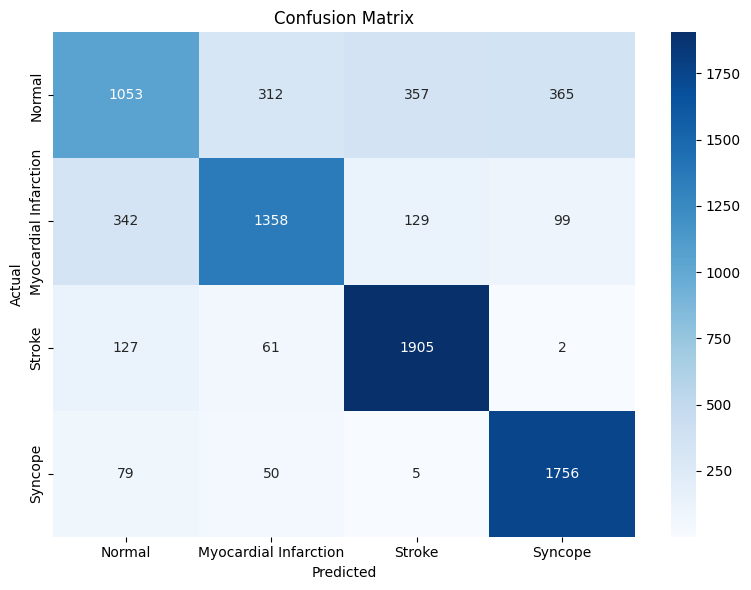

Confusion matrix shape: (4, 4), dtype: int64, values:
[[124  37  50  43]
 [ 49 181  13  11]
 [ 16   6 237   1]
 [  7  11   1 213]]


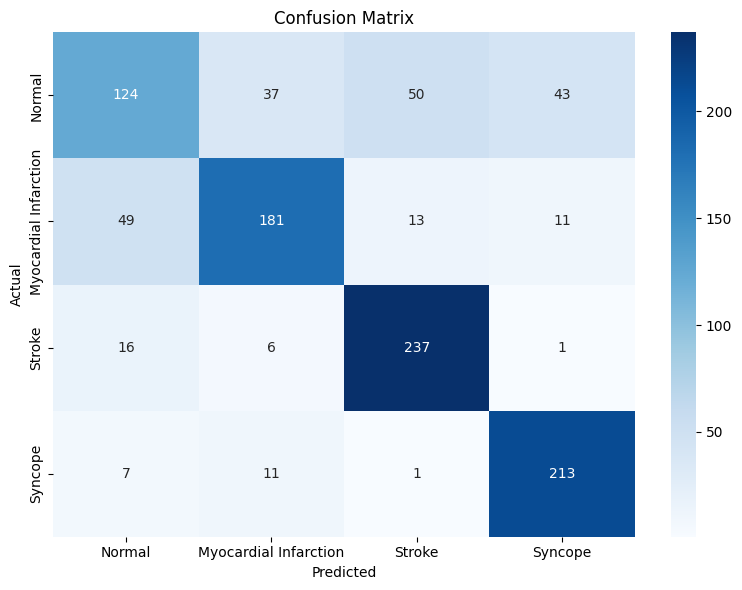

Confusion matrix shape: (4, 4), dtype: int64, values:
[[140  49  40  37]
 [ 46 144  21  11]
 [ 14   9 262   2]
 [  8  12   0 205]]


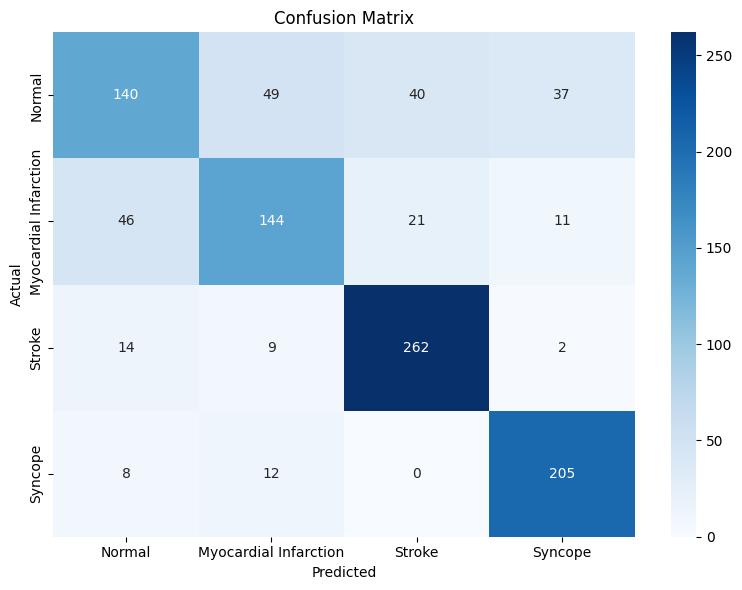

Confusion matrix shape: (4, 4), dtype: int64, values:
[[121   0   0   0]
 [ 11   0   0   0]
 [  3   0   0   0]
 [  3   0   0   0]]


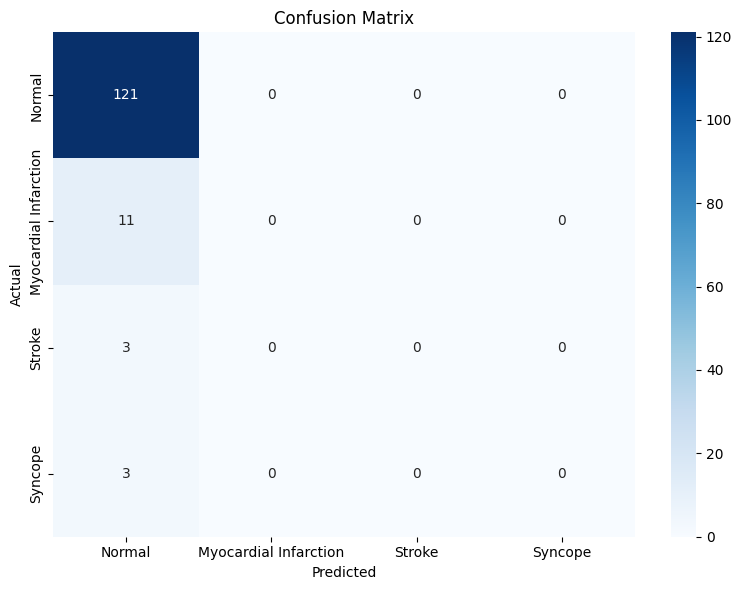

Confusion matrix shape: (4, 4), dtype: int64, values:
[[1316  264  298  190]
 [ 191 1614  104   58]
 [  54   33 1962    3]
 [  38   42    1 1832]]


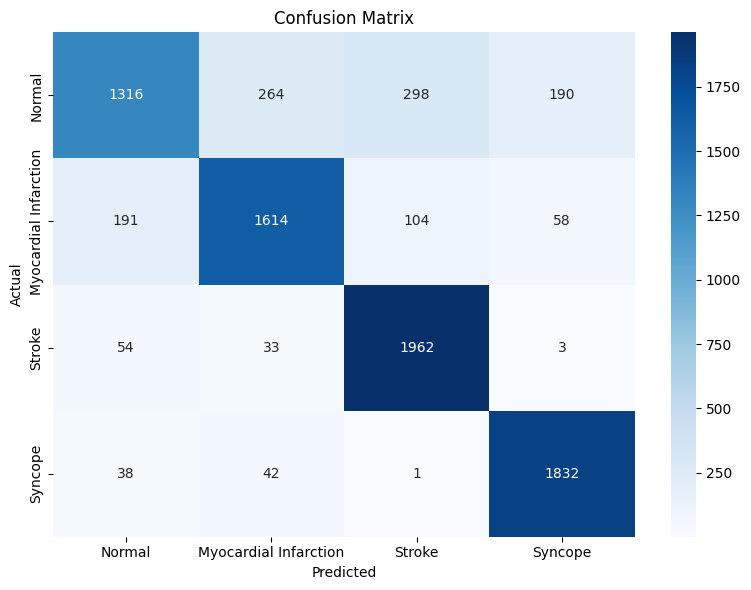

Confusion matrix shape: (4, 4), dtype: int64, values:
[[210   5  37  26]
 [ 61 185   8   8]
 [  6   0 226   0]
 [  3   0   1 224]]


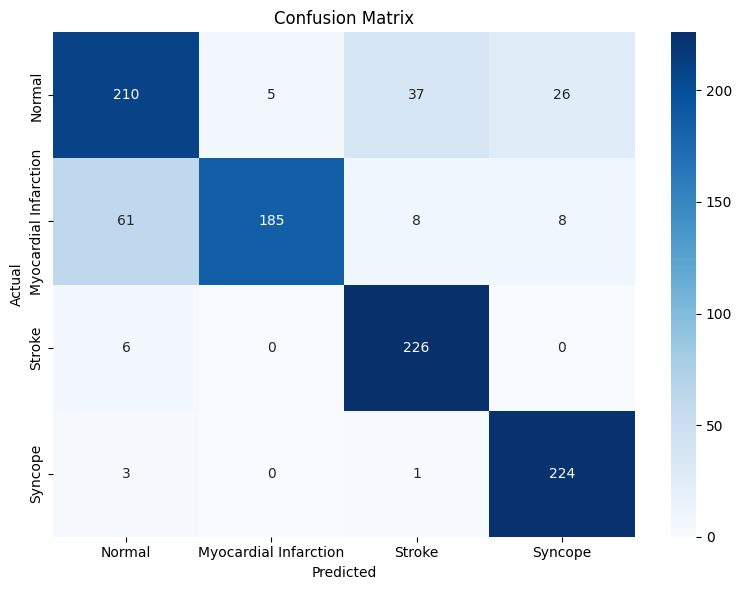

Confusion matrix shape: (4, 4), dtype: int64, values:
[[167   8  30  31]
 [ 69 172  13   7]
 [  6   0 270   2]
 [  6   1   0 218]]


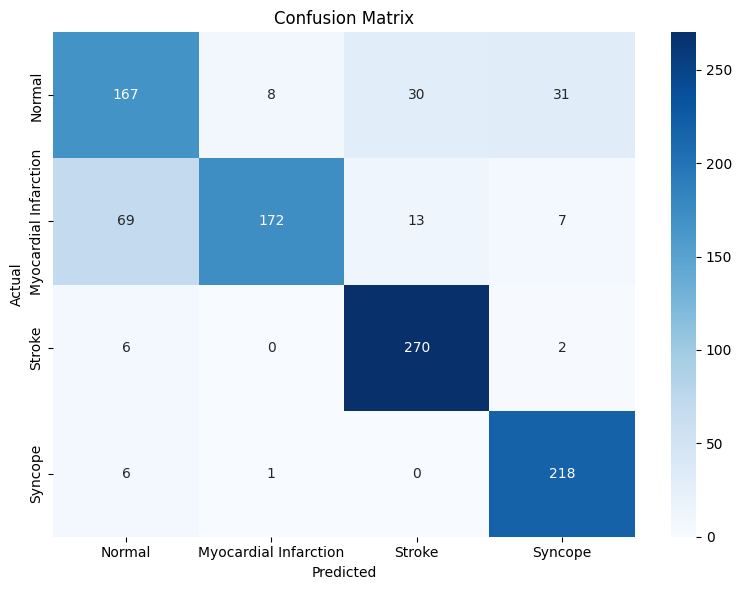

Confusion matrix shape: (4, 4), dtype: int64, values:
[[118   2   0   1]
 [  1  10   0   0]
 [  0   0   3   0]
 [  0   0   0   3]]


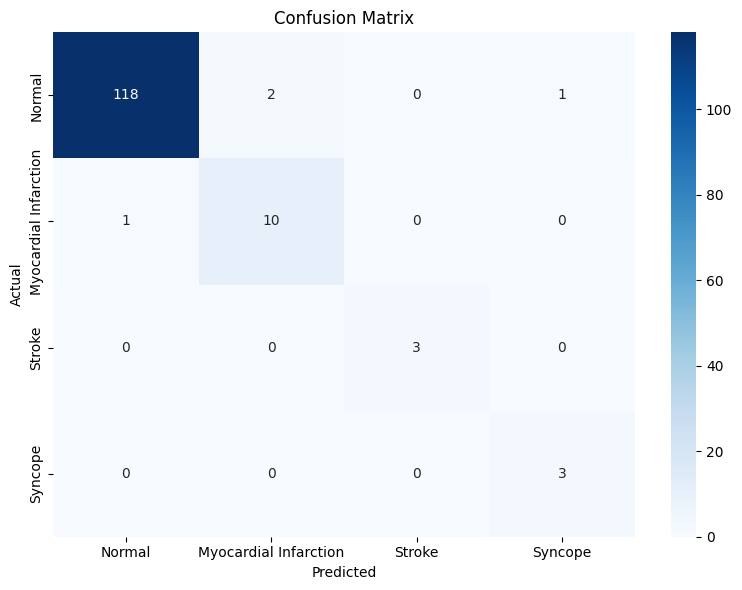

Confusion matrix shape: (4, 4), dtype: int64, values:
[[1940   35    3    5]
 [  26 1957    0    0]
 [   5    0 2032    0]
 [   0    1    0 1996]]


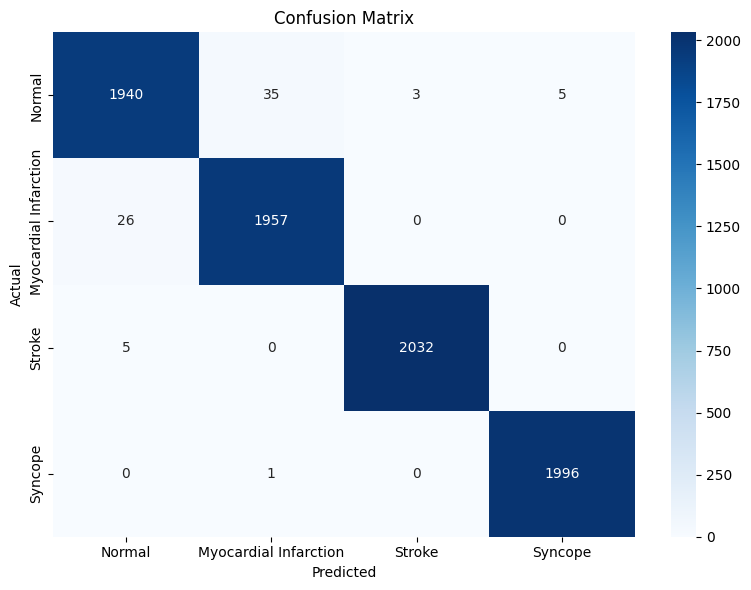

Confusion matrix shape: (4, 4), dtype: int64, values:
[[273   4   0   4]
 [  4 233   0   1]
 [  0   0 268   0]
 [  0   0   0 213]]


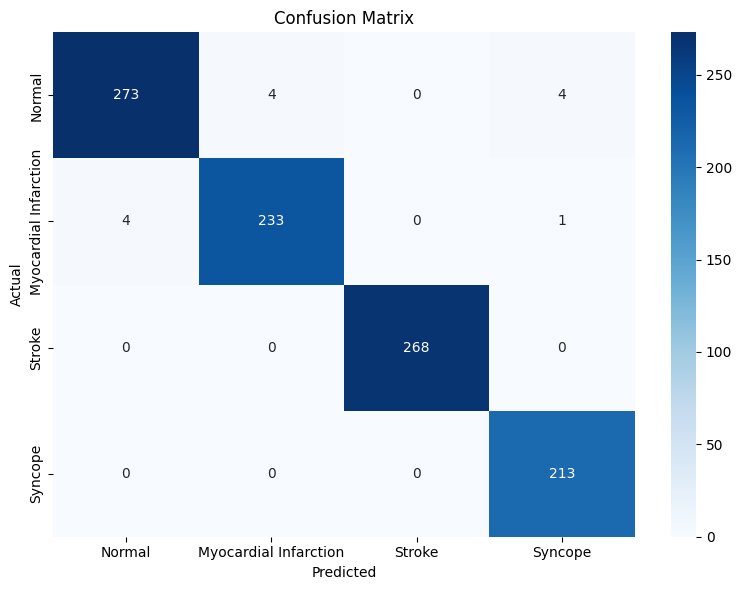

Confusion matrix shape: (4, 4), dtype: int64, values:
[[237  11   1   1]
 [  5 229   1   1]
 [  0   0 247   0]
 [  0   0   0 267]]


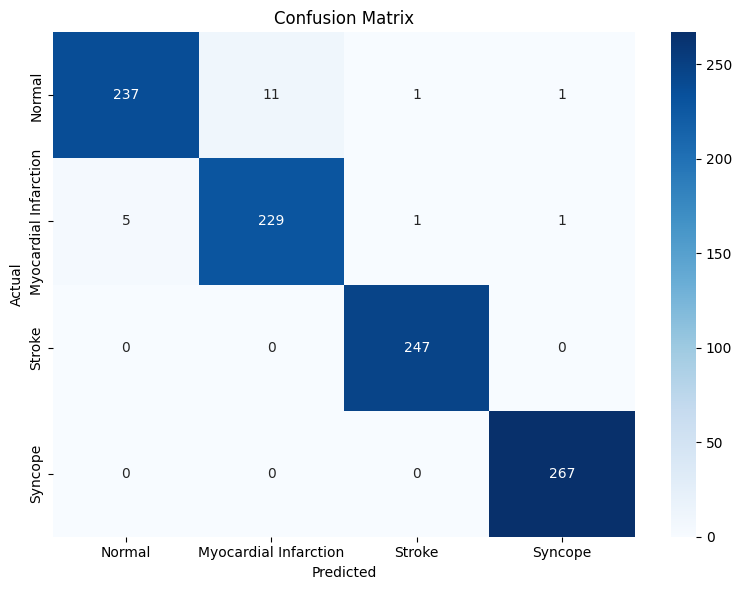

Confusion matrix shape: (4, 4), dtype: int64, values:
[[117   3   1   0]
 [  0  11   0   0]
 [  0   0   3   0]
 [  0   0   0   3]]


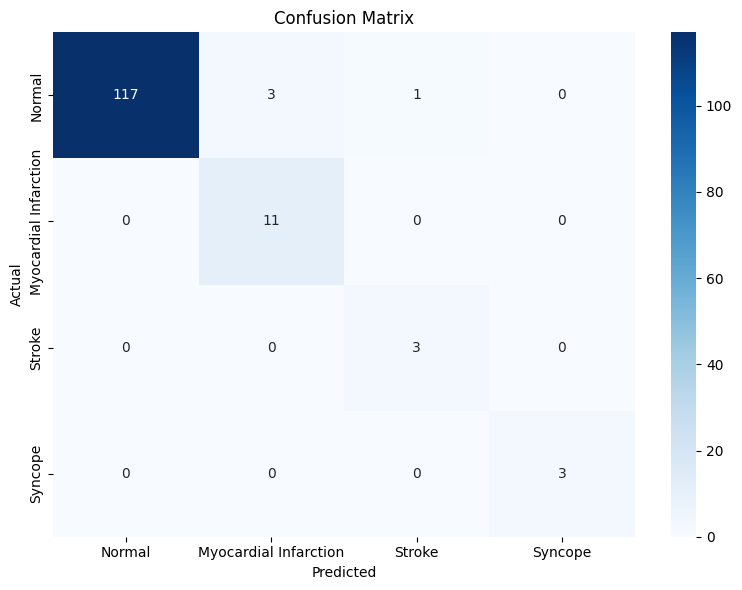

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

datasets = [0,0.5,1]
class_names = ['Normal','Myocardial Infarction', 'Stroke', 'Syncope']
for classifier in range(0,3):
        for dataset in datasets:
            try:
                metrics = torch.load(f"../classifier_models/classifier{classifier}/{dataset}_real_synth_data_classifier.pth", weights_only=False)
                metrics_history = metrics['metrics_history']
                test_metrics = metrics['test_metrics']
                real_test_metrics = metrics['real_test_metrics']
                confusion_matrices = [metrics_history['train_conf_mat'][-1],metrics_history['val_conf_mat'][-1], test_metrics['confusion_matrix'], real_test_metrics['confusion_matrix']]
                for cm in confusion_matrices:
                    if cm is None:
                        print("Confusion matrix is None, skipping.")
                        continue
                    
                    # Convert to numpy if needed
                    if isinstance(cm, torch.Tensor):
                        cm = cm.cpu().numpy()

                    # Check contents
                    print(f"Confusion matrix shape: {cm.shape}, dtype: {cm.dtype}, values:\n{cm}")

                    # Skip empty or invalid shapes
                    if cm.size == 0:
                        print("Confusion matrix is empty, skipping.")
                        continue

                    try:
                        plt.figure(figsize=(8, 6))
                        ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                                        xticklabels=class_names, yticklabels=class_names)
                        plt.xlabel("Predicted")
                        plt.ylabel("Actual")
                        plt.title("Confusion Matrix")
                        plt.tight_layout()
                        plt.show()
                    except Exception as e:
                        print(f"Failed to plot confusion matrix: {e}")
            except: continue

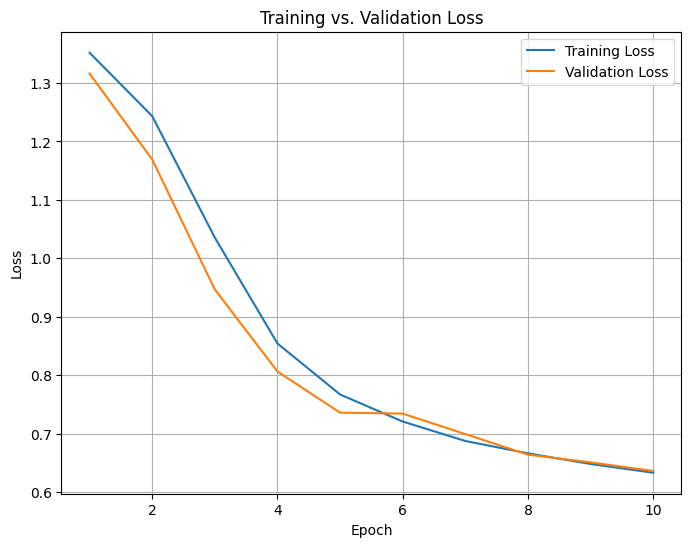

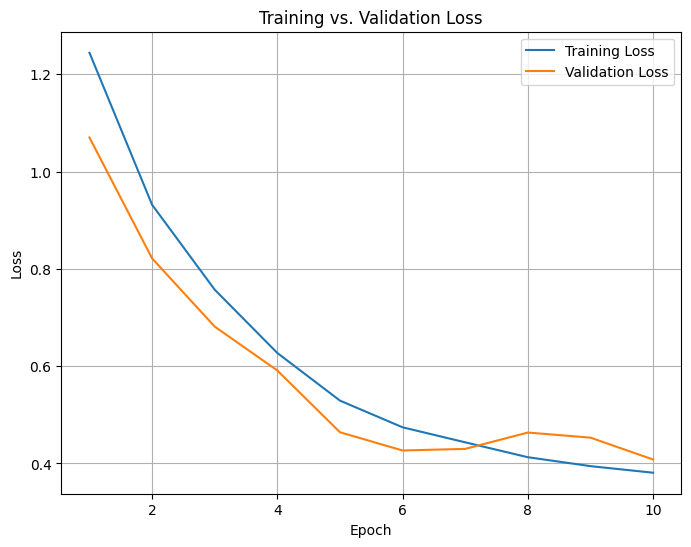

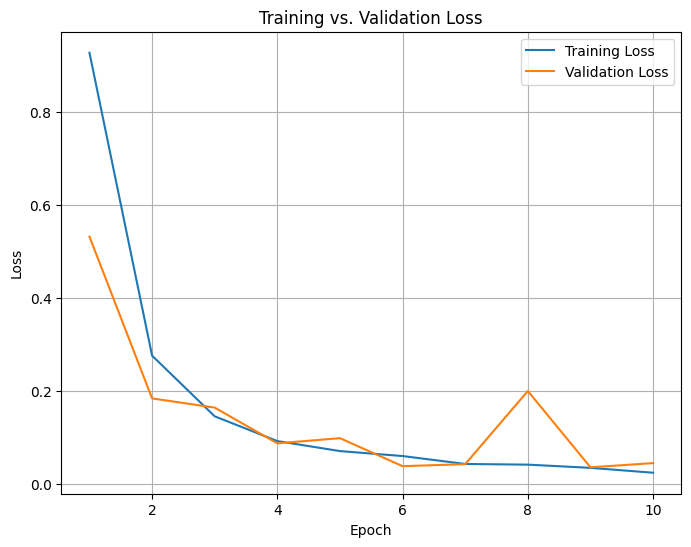

In [48]:
for classifier in range(0,3):
        for dataset in datasets:
            try:
                metrics = torch.load(f"../classifier_models/classifier{classifier}/{dataset}_real_synth_data_classifier.pth", weights_only=False)
                metrics_history = metrics['metrics_history']
                epochs = metrics_history['epoch']
                train_loss = metrics_history['train_loss']
                val_loss = metrics_history['val_loss']
                plt.figure(figsize=(8,6))
                plt.plot(epochs, train_loss, label='Training Loss')
                plt.plot(epochs, val_loss, label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training vs. Validation Loss')
                plt.legend()
                plt.grid(True)
                plt.show()
            except: continue

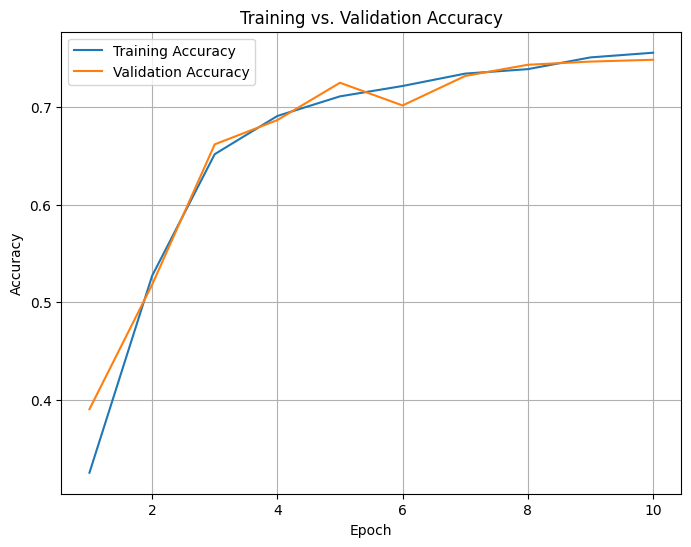

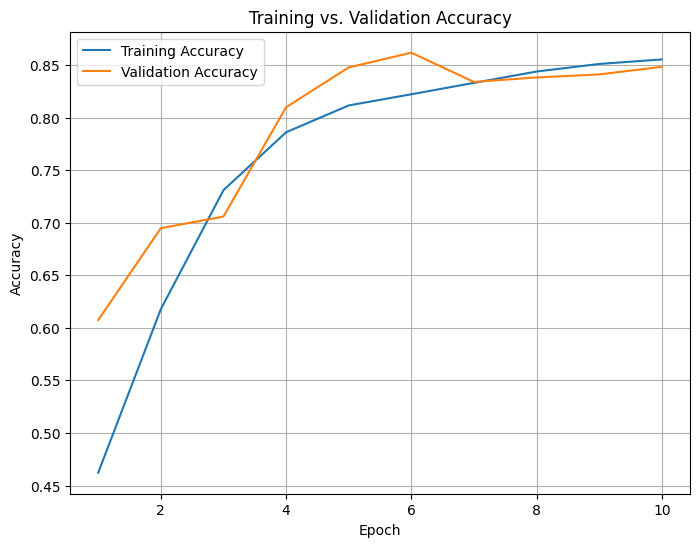

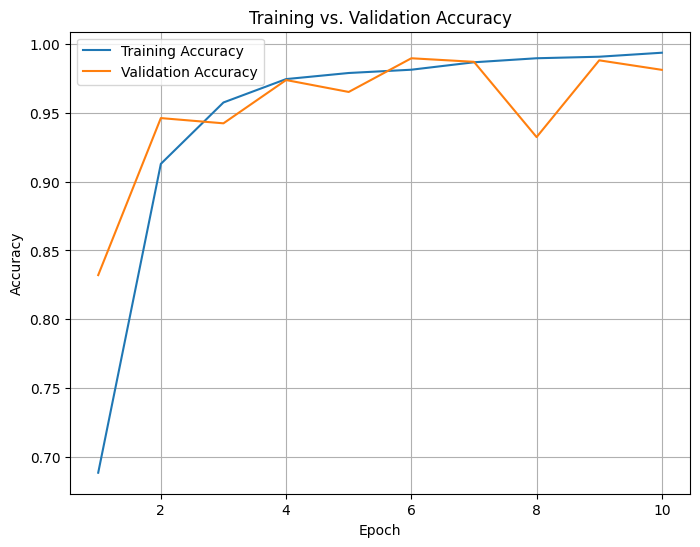

In [49]:
for classifier in range(0,3):
        for dataset in datasets:
            try:
                metrics = torch.load(f"../classifier_models/classifier{classifier}/{dataset}_real_synth_data_classifier.pth", weights_only=False)
                metrics_history = metrics['metrics_history']
                epochs = metrics_history['epoch']
                train_acc = metrics_history['train_accuracy']
                val_acc = metrics_history['val_accuracy']
                plt.figure(figsize=(8,6))
                plt.plot(epochs, train_acc, label='Training Accuracy')
                plt.plot(epochs, val_acc, label='Validation Accuracy')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.title('Training vs. Validation Accuracy')
                plt.legend()
                plt.grid(True)
                plt.show()
            except: continue